# Gpu Configuration

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "GPU(s) física(s),", len(logical_gpus), "GPU(s) lógica(s)")
        print("Funciona")
    except RuntimeError as e:
        print(e)
else:
    print("Error")

1 GPU(s) física(s), 1 GPU(s) lógica(s)
Funciona


# Imports

In [2]:
import xml.etree.ElementTree as ET
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nlpaug.augmenter.word as naw
from tqdm import tqdm
import tensorflow as tf
#from google.colab import drive
import numpy as np
import pandas as pd #cargar los dataset
import keras
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow_hub as hub # para obtener el modelo pre-entrenado de BERT
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
import re
#from bs4 import BeautifulSoup
from tensorflow.keras import layers
import bert
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
import random #mezclar datos
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import os

# Seed definition

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = "1"
    os.environ['TF_CUDNN_DETERMINISM'] = "1"
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)


# With 5 emotions

## Isear dataset

In [3]:
isear = pd.read_excel('ISEAR.xlsx')


print(isear.head())

      ID  CITY  COUN  SUBJ  SEX  AGE  RELI  PRAC  FOCC  MOCC  ...  SELF  RELA  \
0  11001     1     1     1    1   33     1     2     6     1  ...     3     3   
1  11001     1     1     1    1   33     1     2     6     1  ...     2     2   
2  11001     1     1     1    1   33     1     2     6     1  ...     2     1   
3  11001     1     1     1    1   33     1     2     6     1  ...     1     1   
4  11001     1     1     1    1   33     1     2     6     1  ...     0     2   

   VERBAL  NEUTRO   Field1  Field3  Field2   MYKEY  \
0       2       0      joy       4       3  110011   
1       0       0     fear       3       2  110012   
2       0       0    anger       1       3  110013   
3       0       2  sadness       4       4  110014   
4       0       0  disgust       4       4  110015   

                                                 SIT  STATE  
0  During the period of falling in love, each tim...      1  
1         When I was involved in a traffic accident.      1  
2 

In [4]:
isearDataset = isear.iloc[:, [40,36]]
isearDataset = isearDataset.rename(columns={'Field1': 'label', 'SIT': 'texto'})
isearDataset

,texto,label
0,"During the period of falling in love, each tim...",joy
1,When I was involved in a traffic accident.,fear
2,When I was driving home after several days of...,anger
3,When I lost the person who meant the most to me.,sadness
4,The time I knocked a deer down - the sight of ...,disgust
...,...,...
7661,Two years back someone invited me to be the tu...,anger
7662,I had taken the responsibility to do something...,sadness
7663,I was at home and I heard a loud sound of spit...,disgust
7664,I did not do the homework that the teacher had...,shame


In [5]:
def eliminarAcentos(texto):
    texto = texto.replace('á', '')
    texto = texto.replace('\n', '')
    return texto
isearDataset['texto'] = isearDataset['texto'].apply(eliminarAcentos)

In [6]:
isearDataset = isearDataset.replace(to_replace=['joy', 'anger', 'sadness'], value=['happy', 'angry', 'sad']) #Reemplazar nombres de datos
isearDataset = isearDataset.drop(isearDataset[isearDataset['label']== 'shame'].index) #Eliminar nombres de datos de emociones que no se ocupan
isearDataset = isearDataset.drop(isearDataset[isearDataset['label']== 'guilt'].index)
isearDataset = isearDataset.drop(isearDataset[isearDataset['label']== 'guit'].index)
isearDataset = isearDataset.reset_index(drop=True)
isearDataset

,texto,label
0,"During the period of falling in love, each tim...",happy
1,When I was involved in a traffic accident.,fear
2,When I was driving home after several days of...,angry
3,When I lost the person who meant the most to me.,sad
4,The time I knocked a deer down - the sight of ...,disgust
...,...,...
5472,I received a letter from a distant friend.,happy
5473,My parents were out and I was the eldest at ho...,fear
5474,Two years back someone invited me to be the tu...,angry
5475,I had taken the responsibility to do something...,sad


In [8]:
isearDataset.describe()

,texto,label
count,5477,5477
unique,5384,5
top,[ No response.],angry
freq,42,1096


In [64]:
isearDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5477 entries, 0 to 5476
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texto   5477 non-null   object
 1   label   5477 non-null   object
dtypes: object(2)
memory usage: 85.7+ KB


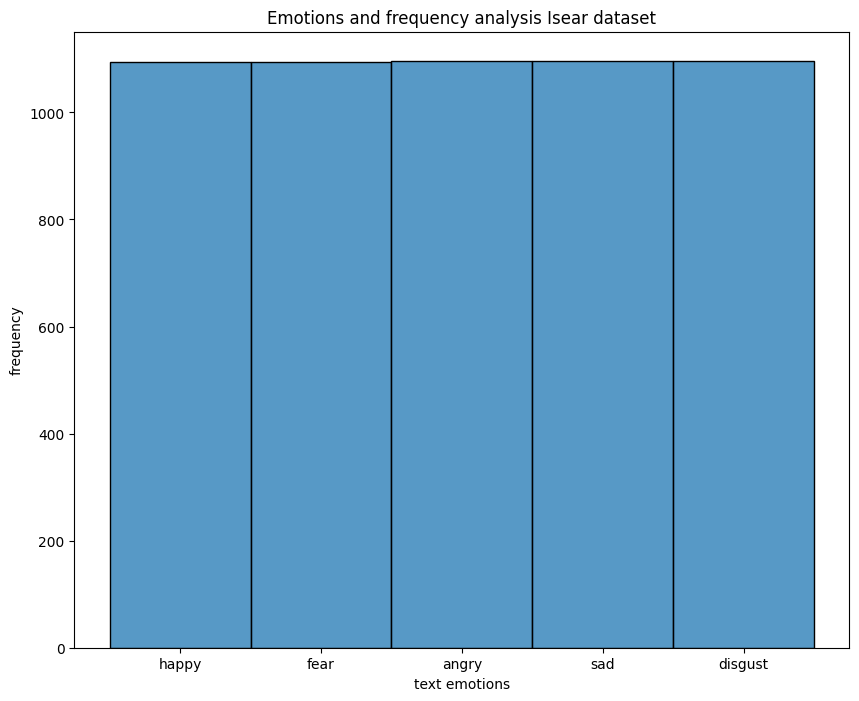

In [79]:
plt.figure(figsize=(10,8))
sns.histplot(isearDataset['label'])
plt.xlabel('text emotions')
plt.ylabel('frequency')
plt.title('Emotions and frequency analysis Isear dataset')
plt.show()

In [66]:
isearDataset['label'].value_counts()


label
angry      1096
sad        1096
disgust    1096
fear       1095
happy      1094
Name: count, dtype: int64

In [67]:
isearDataset['label'].unique()


array(['happy', 'fear', 'angry', 'sad', 'disgust'], dtype=object)

## Clean emotions text

In [7]:
import re

def clean_emotion_text(texto):
    if isinstance(texto, list): #En caso de ser lista toma el primer valor
        texto = texto[0] 

    if texto.startswith('[') and texto.endswith(']'): #Si empieza y termina con [ ] los elimina
        texto = texto[1:-1]

    texto = texto.lower()

    texto = texto.replace('á', '')
    texto = texto.replace('\n', '')
    texto = texto.replace('[]', "'")
    texto = texto.replace('', "'")

    texto = re.sub(r"@[A-Za-z0-9]+", ' ', texto)
    texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)
    texto = re.sub(r"[^a-zA-Z.'!?]", ' ', texto)
    texto = re.sub(r"#", ' ', texto)
    texto = re.sub(r"\s(?=\')", "", texto) #Eliminar los espacios que une los apóstrofes
    texto = texto.replace("' ", "'")
    texto = re.sub(r" +", ' ', texto)


    return texto

# Llamado a la función de limpieza
texto_clean = [clean_emotion_text(text) for text in tqdm(isearDataset['texto'])]

100%|██████████| 5477/5477 [00:00<00:00, 44377.61it/s]


## Transformations from classes to numerics

In [8]:
labels = isearDataset['label']

le = LabelEncoder()

labelEncoder = le.fit_transform(labels)

data_labels = labelEncoder

In [10]:
# Obtener los nombres de las clases
class_names = le.classes_

# Obtener los valores numéricos asignados a cada clase
class_values = le.transform(class_names)

# Imprimir los nombres de las clases y sus valores numéricos
for name, value in zip(class_names, class_values):
    print(f'Clase: {name}, Valor: {value}')

Clase: angry, Valor: 0
Clase: disgust, Valor: 1
Clase: fear, Valor: 2
Clase: happy, Valor: 3
Clase: sad, Valor: 4


## Division of the training set, testing and validation

In [9]:
x_train, x_test, y_train, y_test = train_test_split(texto_clean, data_labels, random_state=42, stratify=data_labels, test_size=0.1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=42, stratify=y_train, test_size=0.2222)

In [10]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

## Data augmentation for text

In [17]:
from textattack.augmentation import EasyDataAugmenter
from tqdm import tqdm
import random
import numpy as np


# Create augmenter
augmenter = EasyDataAugmenter()

# Function to apply the text augmentation
def augment_text(text, label):
    set_seed(42)
    augmented_texts = augmenter.augment(text)
    augmented_data = [(augmented_text, label) for augmented_text in augmented_texts]
    return augmented_data

# Convert zip result to list
data_with_labels = list(zip(x_train, y_train))

# Apply text augmentation to each text in texto_clean 
augmented_data_list = [augment_text(text, label) for text, label in tqdm(data_with_labels, total=len(data_with_labels))]

# Flatten the list of list
augmented_data_flat = [item for sublist in augmented_data_list for item in sublist]

# Extract the generated phrases and labels
x_train_augmented = [augmented_text for augmented_text, label in augmented_data_flat]
y_train_augmented = [label for augmented_text, label in augmented_data_flat]

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
100%|██████████| 3833/3833 [14:13<00:00,  4.49it/s]  


In [21]:
"""#Save Augmented data

import pandas as pd

df_augmented = pd.DataFrame({'Texto': x_train_augmented, 'Label': y_train_augmented})

df_augmented.to_csv('datos_aumentados.csv', index=False)"""


In [11]:
import pandas as pd

# Load the csv file into a dataframe
df_recuperado = pd.read_csv('datos_aumentados_with5emotions.csv')

# Get the augmentation data and labels
x_train_augmented = df_recuperado['Texto'].tolist()
y_train_augmented = df_recuperado['Label'].tolist()


## Glove and Word2Vec Embeddings

In [12]:
# Defining pre-processing parameters
max_len = 300
vocab_size = 300

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train_augmented)

In [14]:
# Get the word_index
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

9033

In [15]:
X_train_seq = tokenizer.texts_to_sequences(x_train_augmented)
X_val_seq = tokenizer.texts_to_sequences(x_val)
X_test_seq = tokenizer.texts_to_sequences(x_test)

In [16]:
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

### Glove

In [17]:
unique, counts = np.unique(y_train_augmented, return_counts=True)
print(dict(zip(unique, counts)))


word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  

# Load the Glove model file
glove_file = 'glove.6B.300d.txt'
embedding_index = {}
with open(glove_file, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

{0: 3068, 1: 3068, 2: 3062, 3: 3063, 4: 3066}


In [20]:
X_train_padded

array([[   8,    6,   72, ...,    0,    0,    0],
       [   8,    6,   72, ...,    0,    0,    0],
       [   8,    6, 1102, ...,    0,    0,    0],
       ...,
       [ 183,   18,   13, ...,    0,    0,    0],
       [  18,   13,    1, ...,    0,    0,    0],
       [  18,  183,   13, ...,    0,    0,    0]])

In [19]:
y_train_augmented = np.array(y_train_augmented)


In [22]:
y_train_augmented

array([0, 0, 0, ..., 4, 4, 4])

In [23]:
y_val

array([4, 1, 3, ..., 4, 0, 1])

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint


# Definir el modelo
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=300, input_length=max_len, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

checkpoint_path = 'model/Glove/64batch/GloVe_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpointGloVe = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)

# Entrenar el modelo
history = model.fit(X_train_padded, y_train_augmented, epochs=20, batch_size=64, validation_data=(X_val_padded, y_val), shuffle=True, callbacks=[model_checkpointGloVe])

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 300)          2710200   
                                                                 
 bidirectional_2 (Bidirectio  (None, 300, 128)         186880    
 nal)                                                            
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 5)                

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = y_test
y_pred = model.predict(X_test_padded).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

18/18 [==============================] - 1s 36ms/step
              precision    recall  f1-score   support

           0       0.59      0.66      0.62       110
           1       0.60      0.59      0.59       110
           2       0.79      0.76      0.78       109
           3       0.80      0.79      0.79       109
           4       0.68      0.63      0.65       110

    accuracy                           0.69       548
   macro avg       0.69      0.69      0.69       548
weighted avg       0.69      0.69      0.69       548

<function confusion_matrix at 0x0000024E0B07EDD0>


In [47]:
y_train_augmented.shape


(15327,)

In [48]:
y_val.shape

(1096,)

In [54]:
print(f'y_train_augmented shape: {y_train_augmented.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'y_test shape: {y_test.shape}')


y_train_augmented shape: (15327,)
y_val shape: (1096,)
y_test shape: (548,)


In [55]:
y_train_one_hot = to_categorical(y_train_augmented, num_classes=5)
y_val_one_hot = to_categorical(y_val, num_classes=5)
y_test_one_hot = to_categorical(y_test, num_classes=5)

In [56]:
y_train_one_hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [61]:
input_layer = tf.keras.layers.Input(shape=(max_len,))

embd = Embedding(input_dim=vocab_size, output_dim=300, input_length=max_len, weights=[embedding_matrix], trainable=False)(input_layer)
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(embd)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(embd)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(embd)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
modelGlove = tf.keras.models.Model(inputs=input_layer, outputs=dense_output)

modelGlove.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
modelGlove.summary()


print(modelGlove.summary())


history = modelGlove.fit(X_train_padded, y_train_one_hot, epochs=20, batch_size=128, validation_data=(X_val_padded,y_val_one_hot), shuffle=True)



Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 300, 300)     2722500     ['input_8[0][0]']                
                                                                                                  
 conv1d_21 (Conv1D)             (None, 300, 128)     76928       ['embedding_7[0][0]']            
                                                                                                  
 conv1d_22 (Conv1D)             (None, 300, 128)     115328      ['embedding_7[0][0]']            
                                                                                            

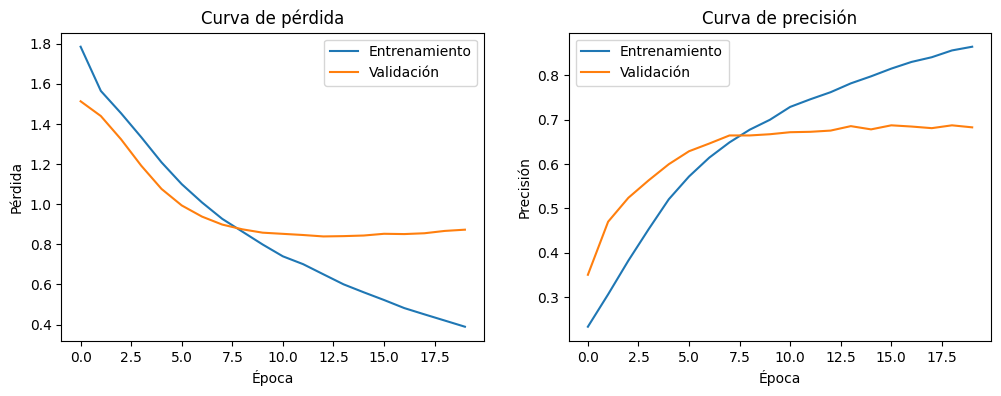

In [62]:
import matplotlib.pyplot as plt


train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [65]:
evaluation_result = modelGlove.evaluate(X_test_padded, y_test_one_hot)
print(f'Test Loss: {evaluation_result[0]}, Test Accuracy: {evaluation_result[1]*100:.2f}%')


18/18 [==============================] - 0s 14ms/step - loss: 0.9115 - accuracy: 0.6697 - recall_7: 0.6113
Test Loss: 0.9114594459533691, Test Accuracy: 66.97%


### Word2Vec

In [31]:
y_train_one_hot = to_categorical(y_train_augmented, num_classes=5)
y_val_one_hot = to_categorical(y_val, num_classes=5)
y_test_one_hot = to_categorical(y_test, num_classes=5)

In [32]:
from gensim.models import KeyedVectors

unique, counts = np.unique(y_train_augmented, return_counts=True)
print(dict(zip(unique, counts)))


word_index = tokenizer.word_index
vocab_size = len(word_index) + 1 


# Load Word2vec model file
word2vec = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# Create embedding matrix
embedding_matrix_word2vec = np.zeros((vocab_size, 300))
for word, i in word_index.items():
    if word in word2vec:
        embedding_matrix_word2vec[i] = word2vec[word]

{0: 3068, 1: 3068, 2: 3062, 3: 3063, 4: 3066}


In [33]:
input_layer = tf.keras.layers.Input(shape=(max_len,))

embd = Embedding(input_dim=vocab_size, output_dim=300, input_length=max_len, weights=[embedding_matrix_word2vec], trainable=False)(input_layer)
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(embd)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(embd)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(embd)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
modelWord2vec1 = tf.keras.models.Model(inputs=input_layer, outputs=dense_output)

modelWord2vec1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
modelWord2vec1.summary()


print(modelWord2vec1.summary())


checkpoint_path = 'model/Word2Vec/64batch/GloVe_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpointWord2Vec = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


historyWord2vec1 = modelWord2vec1.fit(X_train_padded, y_train_one_hot, epochs=20, batch_size=128, validation_data=(X_val_padded,y_val_one_hot), shuffle=True, callbacks=[model_checkpointWord2Vec])

print(modelWord2vec1.evaluate(X_test_padded,y_test_one_hot))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 300, 300)     2710200     ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 300, 128)     76928       ['embedding_3[0][0]']            
                                                                                                  
 conv1d_1 (Conv1D)              (None, 300, 128)     115328      ['embedding_3[0][0]']            
                                                                                              

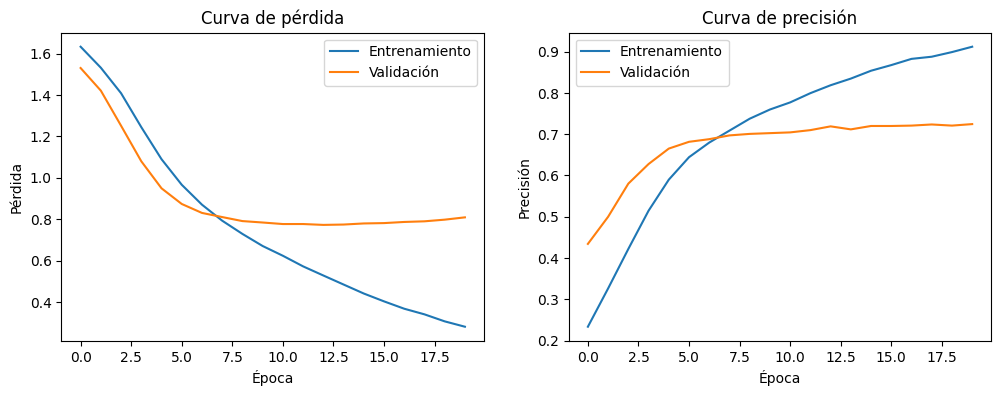

In [34]:
import matplotlib.pyplot as plt


train_loss = historyWord2vec1.history['loss']
val_loss = historyWord2vec1.history['val_loss']
train_accuracy = historyWord2vec1.history['accuracy']
val_accuracy = historyWord2vec1.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [35]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = y_test
y_pred = modelWord2vec1.predict(X_test_padded).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

18/18 [==============================] - 0s 19ms/step
              precision    recall  f1-score   support

           0       0.65      0.66      0.65       110
           1       0.72      0.65      0.68       110
           2       0.78      0.78      0.78       109
           3       0.72      0.86      0.79       109
           4       0.70      0.63      0.66       110

    accuracy                           0.72       548
   macro avg       0.72      0.72      0.71       548
weighted avg       0.72      0.72      0.71       548

<function confusion_matrix at 0x0000024E0B07EDD0>


## Definition Bert and Roberta

In [37]:
from transformers import BertTokenizer, TFBertModel,RobertaTokenizer,TFRobertaModel

tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

tokenizer_roberta = RobertaTokenizer.from_pretrained("FacebookAI/roberta-base")
roberta_model = TFRobertaModel.from_pretrained("FacebookAI/roberta-base")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

### Embedding Bert

In [38]:
def tokenizer_bert_fn(texts, labels):
    input_ids = []
    attention_masks = []
    label_array = tf.one_hot(labels, depth=5)

    for text in texts:
        inputs = tokenizer_bert(text, 
                                padding="max_length", 
                                truncation=True,
                                max_length=300,
                                return_tensors='tf')
        input_ids.append(inputs['input_ids'])
        attention_masks.append(inputs['attention_mask'])

    return np.array(input_ids), np.array(attention_masks), label_array

input_ids_train, attention_mask_train, labels_train = tokenizer_bert_fn(x_train_augmented, y_train_augmented)
input_ids_test, attention_mask_test, labels_test = tokenizer_bert_fn(x_test, y_test)
input_ids_val, attention_mask_val, labels_val = tokenizer_bert_fn(x_val, y_val)

input_ids_train = np.squeeze(input_ids_train, axis=1)
attention_mask_train = np.squeeze(attention_mask_train, axis=1)

input_ids_test = np.squeeze(input_ids_test, axis=1)
attention_mask_test = np.squeeze(attention_mask_test, axis=1)

input_ids_val = np.squeeze(input_ids_val, axis=1)
attention_mask_val = np.squeeze(attention_mask_val, axis=1)


### Embedding Roberta

In [42]:
def tokenizer_roberta_fn(texts, labels):
    input_ids = []
    attention_masks = []
    label_array = tf.one_hot(labels, depth=5)

    for text in texts:
        inputs = tokenizer_roberta(text, 
                                padding="max_length", 
                                truncation=True,
                                max_length=300,
                                return_tensors='tf')
        input_ids.append(inputs['input_ids'])
        attention_masks.append(inputs['attention_mask'])

    return np.array(input_ids), np.array(attention_masks), label_array

input_ids_train_roberta, attention_mask_train_roberta, labels_train_roberta = tokenizer_roberta_fn(x_train_augmented, y_train_augmented)
input_ids_test_roberta, attention_mask_test_roberta, labels_test_roberta = tokenizer_roberta_fn(x_test, y_test)
input_ids_val_roberta, attention_mask_val_roberta, labels_val_roberta = tokenizer_roberta_fn(x_val, y_val)

input_ids_train_roberta = np.squeeze(input_ids_train_roberta, axis=1)
attention_mask_train_roberta = np.squeeze(attention_mask_train_roberta, axis=1)

input_ids_test_roberta = np.squeeze(input_ids_test_roberta, axis=1)
attention_mask_test_roberta = np.squeeze(attention_mask_test_roberta, axis=1)

input_ids_val_roberta = np.squeeze(input_ids_val_roberta, axis=1)
attention_mask_val_roberta = np.squeeze(attention_mask_val_roberta, axis=1)

## Models Bert

### Model 1 Bert + BiLstm-CNN Duo

In [59]:
from transformers import TFBertModel
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

bert_model.trainable = False

input_ids = tf.keras.Input(shape=(300,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.Input(shape=(300,), dtype=tf.int32, name='attention_mask')

bert_output = bert_model([input_ids, attention_mask])[0]

bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(bert_output)
x1 = Conv1D(32, 3, activation='relu')(bilstm)
x1 = Conv1D(32, 5, activation='relu')(x1)
x1 = tf.keras.layers.Dropout(0.5)(x1)

bilstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(bert_output)
x2 = Conv1D(32, 5, activation='relu')(bilstm)
x2 = Conv1D(32, 3, activation='relu')(x2)
x2 = tf.keras.layers.Dropout(0.5)(x2)

xconcat = tf.concat([x1,x2], axis=-1)
pooled = GlobalMaxPooling1D()(xconcat)
dropout= tf.keras.layers.Dropout(0.5)(pooled)
output_layer = Dense(256, activation='relu')(dropout)
output = Dense(5, activation='softmax')(output_layer)

model2 = Model(inputs=[input_ids, attention_mask], outputs=output)

model2.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history2 = model2.fit([input_ids_train, attention_mask_train], labels_train, validation_data=([input_ids_val, attention_mask_val], labels_val), epochs=15, batch_size=128, callbacks = [early_stopping], shuffle=True)

Epoch 1/15
120/120 [==============================] - 259s 2s/step - loss: 1.1145 - accuracy: 0.5462 - val_loss: 0.8709 - val_accuracy: 0.7044
Epoch 2/15
120/120 [==============================] - 239s 2s/step - loss: 0.7969 - accuracy: 0.7109 - val_loss: 0.7823 - val_accuracy: 0.7217
Epoch 3/15
120/120 [==============================] - 240s 2s/step - loss: 0.6720 - accuracy: 0.7574 - val_loss: 0.6745 - val_accuracy: 0.7710
Epoch 4/15
120/120 [==============================] - 239s 2s/step - loss: 0.5903 - accuracy: 0.7896 - val_loss: 0.6846 - val_accuracy: 0.7619
Epoch 5/15
120/120 [==============================] - 239s 2s/step - loss: 0.4879 - accuracy: 0.8250 - val_loss: 0.6380 - val_accuracy: 0.7637
Epoch 6/15
120/120 [==============================] - 239s 2s/step - loss: 0.4195 - accuracy: 0.8538 - val_loss: 0.6382 - val_accuracy: 0.7536
Epoch 7/15
120/120 [==============================] - 240s 2s/step - loss: 0.3752 - accuracy: 0.8635 - val_loss: 0.6212 - val_accuracy: 0.7719

In [60]:
model2.evaluate([input_ids_test, attention_mask_test], labels_test)

18/18 [==============================] - 8s 423ms/step - loss: 0.7207 - accuracy: 0.7518


[0.72074294090271, 0.7518247961997986]

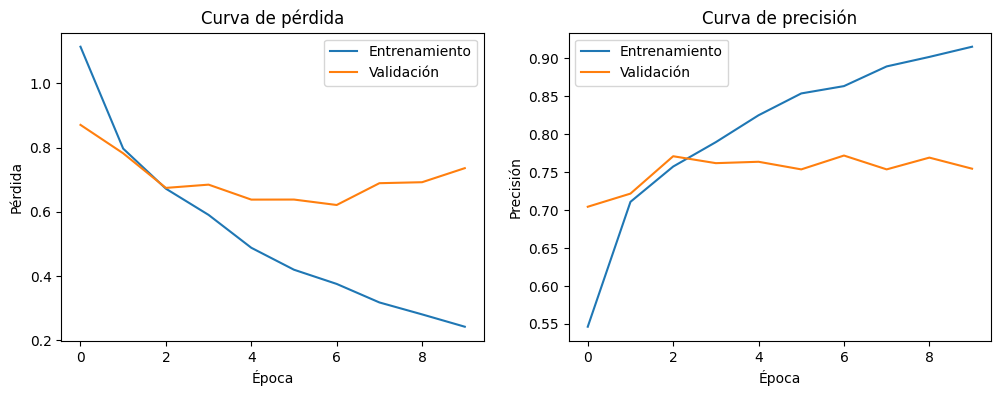

In [61]:
import matplotlib.pyplot as plt


train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
train_accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Model 2 bert + Ngram CNN - 64 filters

In [55]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(64,2,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(64,3,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(64,4,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
model = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model.layers[2].trainable=False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_12[0][0]',               
                                thPoolingAndCrossAt               'input_13[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [56]:
history = model.fit(
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=10,
    callbacks = [early_stopping], batch_size=128, shuffle=True
)

Epoch 1/10
120/120 [==============================] - 250s 2s/step - loss: 1.8516 - accuracy: 0.2571 - recall_5: 0.0855 - val_loss: 1.3534 - val_accuracy: 0.5584 - val_recall_5: 0.0064
Epoch 2/10
120/120 [==============================] - 234s 2s/step - loss: 1.4205 - accuracy: 0.3972 - recall_5: 0.1057 - val_loss: 1.1091 - val_accuracy: 0.6332 - val_recall_5: 0.1980
Epoch 3/10
120/120 [==============================] - 234s 2s/step - loss: 1.2034 - accuracy: 0.5175 - recall_5: 0.2572 - val_loss: 0.9091 - val_accuracy: 0.6734 - val_recall_5: 0.4617
Epoch 4/10
120/120 [==============================] - 234s 2s/step - loss: 1.0537 - accuracy: 0.5900 - recall_5: 0.3918 - val_loss: 0.7996 - val_accuracy: 0.7089 - val_recall_5: 0.5766
Epoch 5/10
120/120 [==============================] - 234s 2s/step - loss: 0.9656 - accuracy: 0.6280 - recall_5: 0.4618 - val_loss: 0.7331 - val_accuracy: 0.7318 - val_recall_5: 0.6223
Epoch 6/10
120/120 [==============================] - 234s 2s/step - loss: 

In [62]:
model.evaluate([input_ids_test, attention_mask_test], labels_test)

18/18 [==============================] - 7s 399ms/step - loss: 0.6588 - accuracy: 0.7646 - recall_5: 0.6953


[0.6588402390480042, 0.764598548412323, 0.69525545835495]

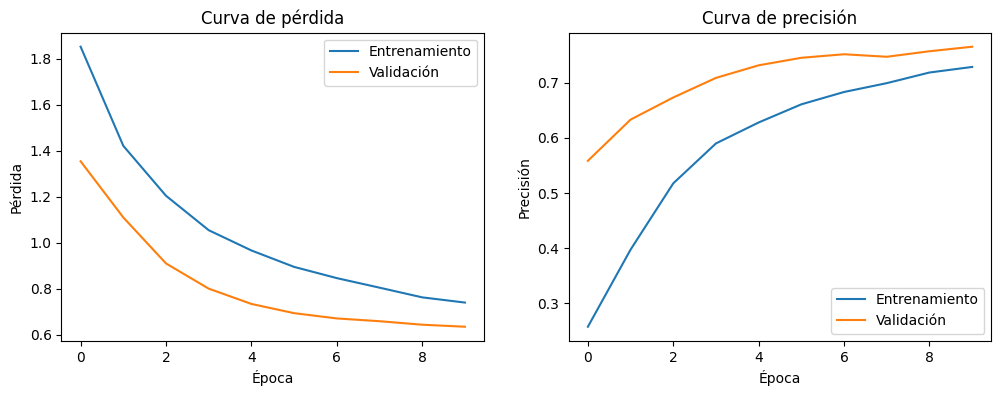

In [57]:
import matplotlib.pyplot as plt


train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Model 3 bert + Ngram CNN - 64 filters - More kernel-size

In [63]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(64,3,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(64,4,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(64,5,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
model3 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model3.layers[2].trainable=False

model3.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
model3.summary()

history3 = model3.fit(
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=15,
    callbacks = [early_stopping], batch_size=128, shuffle=True
)

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_14[0][0]',               
                                thPoolingAndCrossAt               'input_15[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                        

In [64]:
model3.evaluate([input_ids_test, attention_mask_test], labels_test)

18/18 [==============================] - 7s 401ms/step - loss: 0.6385 - accuracy: 0.7536 - recall_6: 0.7044


[0.6384734511375427, 0.7536496520042419, 0.7043795585632324]

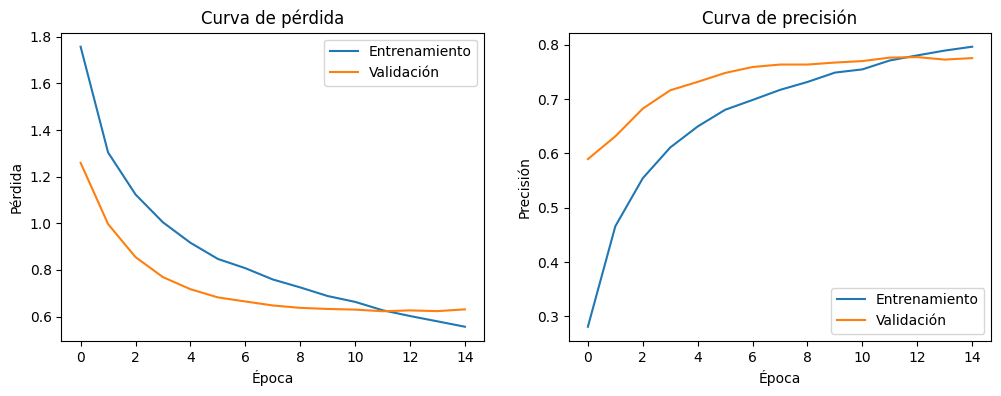

In [65]:
import matplotlib.pyplot as plt


train_loss = history3.history['loss']
val_loss = history3.history['val_loss']
train_accuracy = history3.history['accuracy']
val_accuracy = history3.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Model 4 Bert + BiLstm-CNN Duo - Different units Dense

In [44]:
from transformers import TFBertModel
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

bert_model.trainable = False

input_ids = tf.keras.Input(shape=(300,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.Input(shape=(300,), dtype=tf.int32, name='attention_mask')

bert_output = bert_model([input_ids, attention_mask])[0]

bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(bert_output)
x1 = Conv1D(32, 3, activation='relu')(bilstm)
x1 = Conv1D(32, 5, activation='relu')(x1)
x1 = tf.keras.layers.Dropout(0.5)(x1)

bilstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(bert_output)
x2 = Conv1D(32, 5, activation='relu')(bilstm)
x2 = Conv1D(32, 3, activation='relu')(x2)
x2 = tf.keras.layers.Dropout(0.5)(x2)

xconcat = tf.concat([x1,x2], axis=-1)
pooled = GlobalMaxPooling1D()(xconcat)
dropout= tf.keras.layers.Dropout(0.5)(pooled)
output_layer = Dense(512, activation='relu')(dropout)
dropout_end= tf.keras.layers.Dropout(0.5)(output_layer) 
output = Dense(5, activation='softmax')(dropout_end)

model4 = Model(inputs=[input_ids, attention_mask], outputs=output)

model4.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

checkpoint_path = 'model/BERTHugginfFace/BiLSTMDUO/64batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpointBiLSTMDUO = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history4 = model4.fit([input_ids_train, attention_mask_train], labels_train, validation_data=([input_ids_val, attention_mask_val], labels_val), epochs=15, batch_size=128, callbacks = [early_stopping, model_checkpointBiLSTMDUO], shuffle=True)

Epoch 1/15
120/120 [==============================] - ETA: 0s - loss: 1.2043 - accuracy: 0.4927
Epoch 1: val_accuracy improved from -inf to 0.71259, saving model to model/BERTHugginfFace/BiLSTMDUO/64batch\BERT_CNN_model_best_01_val_0.7126.h5
120/120 [==============================] - 266s 2s/step - loss: 1.2043 - accuracy: 0.4927 - val_loss: 0.9201 - val_accuracy: 0.7126
Epoch 2/15
120/120 [==============================] - ETA: 0s - loss: 0.8216 - accuracy: 0.6969
Epoch 2: val_accuracy improved from 0.71259 to 0.75000, saving model to model/BERTHugginfFace/BiLSTMDUO/64batch\BERT_CNN_model_best_02_val_0.7500.h5
120/120 [==============================] - 242s 2s/step - loss: 0.8216 - accuracy: 0.6969 - val_loss: 0.7795 - val_accuracy: 0.7500
Epoch 3/15
120/120 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.7512
Epoch 3: val_accuracy improved from 0.75000 to 0.75730, saving model to model/BERTHugginfFace/BiLSTMDUO/64batch\BERT_CNN_model_best_03_val_0.7573.h5
120/

In [52]:
def custom_objects_fn_bert():
    return {'TFBertModel': TFBertModel}

model4_load = tf.keras.models.load_model('model/BERTHugginfFace/BiLSTMDUO/64batch\BERT_CNN_model_best_09_val_0.7682.h5', custom_objects=custom_objects_fn_bert())
model4_load.evaluate([input_ids_test, attention_mask_test], labels_test)

18/18 [==============================] - 12s 417ms/step - loss: 0.7363 - accuracy: 0.7445


[0.7362977862358093, 0.7445255517959595]

In [45]:
model4.evaluate([input_ids_test, attention_mask_test], labels_test)

18/18 [==============================] - 10s 513ms/step - loss: 0.6913 - accuracy: 0.7518


[0.6912896037101746, 0.7518247961997986]

In [54]:
from sklearn.metrics import classification_report, confusion_matrix

y_true  = np.argmax(labels_test, axis=-1)
y_pred = model4.predict([input_ids_test, attention_mask_test])
y_pred = np.argmax(y_pred, axis=-1)

report = classification_report(y_true,y_pred)
print(report)

matrix = confusion_matrix(y_true,y_pred)
print(matrix)

18/18 [==============================] - 12s 410ms/step
              precision    recall  f1-score   support

           0       0.77      0.71      0.74       110
           1       0.70      0.67      0.69       110
           2       0.83      0.83      0.83       109
           3       0.78      0.89      0.83       109
           4       0.68      0.66      0.67       110

    accuracy                           0.75       548
   macro avg       0.75      0.75      0.75       548
weighted avg       0.75      0.75      0.75       548

[[78 16  3  3 10]
 [13 74  8  3 12]
 [ 4  3 90  7  5]
 [ 0  2  2 97  8]
 [ 6 11  5 15 73]]


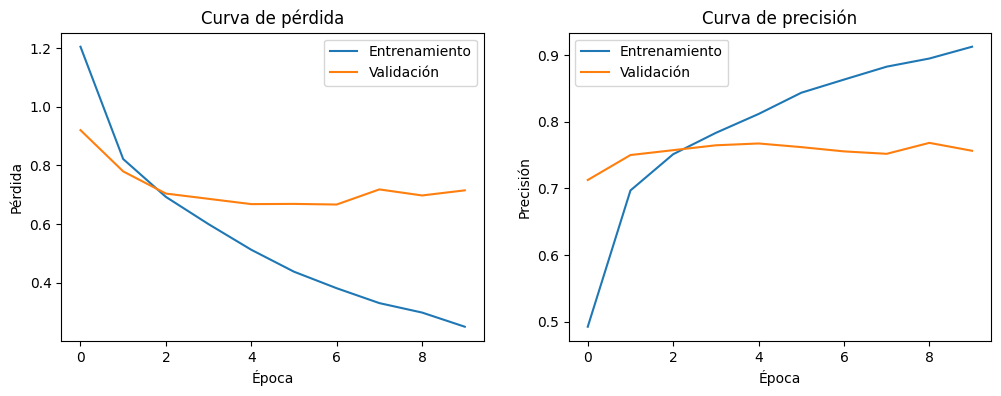

In [53]:
import matplotlib.pyplot as plt


train_loss = history4.history['loss']
val_loss = history4.history['val_loss']
train_accuracy = history4.history['accuracy']
val_accuracy = history4.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Model 5 Bert + Ngram CNN - 32 filters - start kernel size in 200

In [69]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(32,200,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(32,300,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(32,400,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.2)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
model5 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model5.layers[2].trainable=False

model5.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
model5.summary()

import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history5 = model5.fit(
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=15,
    callbacks = [early_stopping], batch_size=64
)

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_17 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_16[0][0]',               
                                thPoolingAndCrossAt               'input_17[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                        

In [70]:
model5.evaluate([input_ids_test, attention_mask_test], labels_test)

18/18 [==============================] - 15s 831ms/step - loss: 0.8188 - accuracy: 0.6953 - recall_7: 0.6350


[0.818799614906311, 0.69525545835495, 0.6350364685058594]

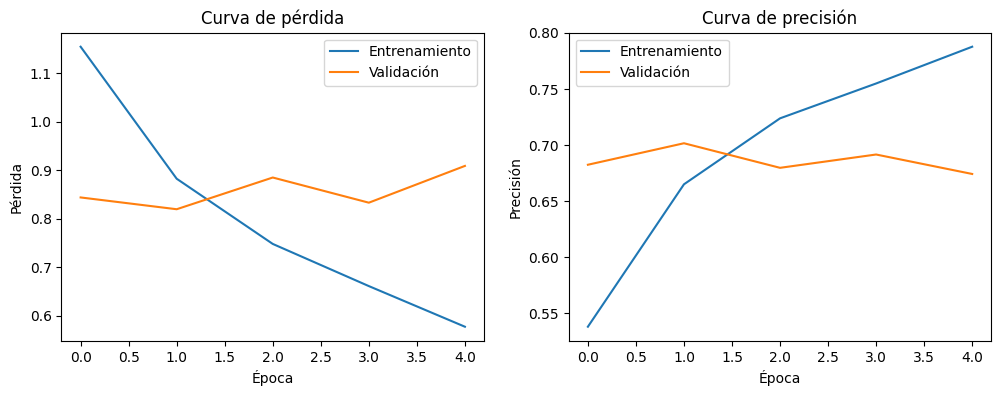

In [71]:
import matplotlib.pyplot as plt


train_loss = history5.history['loss']
val_loss = history5.history['val_loss']
train_accuracy = history5.history['accuracy']
val_accuracy = history5.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Model 6 Bert + Ngram CNN - 32 filters

In [72]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(32,2,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(32,3,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(32,4,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
model6 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model6.layers[2].trainable=False

model6.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
model6.summary()

import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history6 = model6.fit(
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=15,
    callbacks = [early_stopping], batch_size=64
)

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_18[0][0]',               
                                thPoolingAndCrossAt               'input_19[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                        

In [73]:
model6.evaluate([input_ids_test, attention_mask_test], labels_test)

18/18 [==============================] - 7s 401ms/step - loss: 0.6620 - accuracy: 0.7646 - recall_8: 0.6916


[0.6619989275932312, 0.764598548412323, 0.6916058659553528]

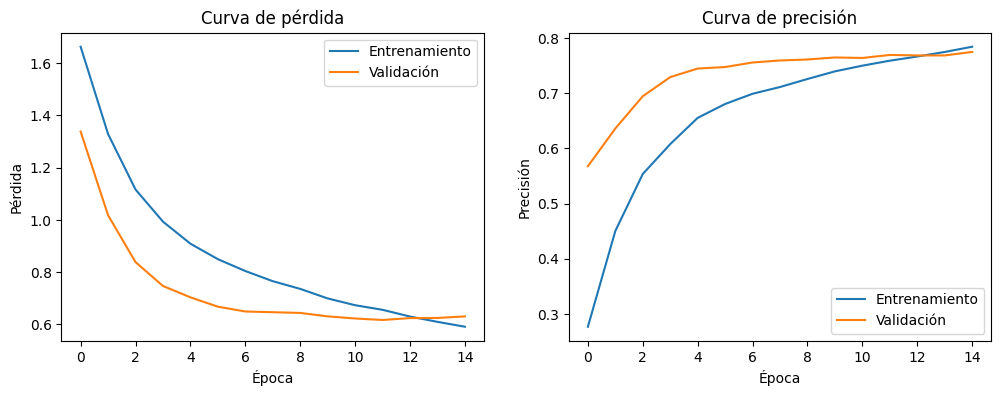

In [74]:
import matplotlib.pyplot as plt


train_loss = history6.history['loss']
val_loss = history6.history['val_loss']
train_accuracy = history6.history['accuracy']
val_accuracy = history6.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Model 7 Bert + Ngram CNN - 64 filters - 4 layers

In [75]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(64,3,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(64,4,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(64,5,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
x_4 = tf.keras.layers.Conv1D(64,6,padding='same', activation='relu')(bert_output)
x_4 = tf.keras.layers.GlobalMaxPooling1D()(x_4)
merged = tf.concat([x_2,x_3,x_4], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
model7 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model7.layers[2].trainable=False

model7.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
model7.summary()

history7 = model7.fit(
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=15,
    callbacks = [early_stopping], batch_size=128, shuffle=True
)

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_21 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_20[0][0]',               
                                thPoolingAndCrossAt               'input_21[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                        

In [77]:
model7.evaluate([input_ids_test, attention_mask_test], labels_test)

18/18 [==============================] - 7s 400ms/step - loss: 0.6858 - accuracy: 0.7591 - recall_9: 0.6971


[0.6857662200927734, 0.7591241002082825, 0.6970803141593933]

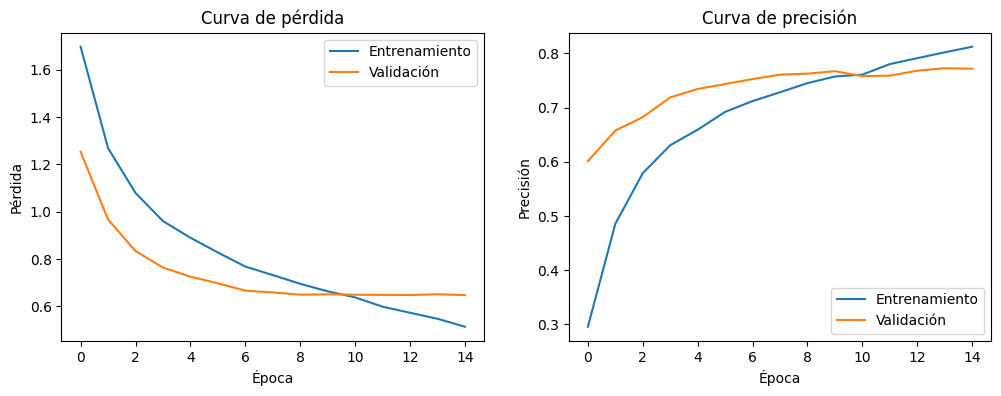

In [76]:
import matplotlib.pyplot as plt


train_loss = history7.history['loss']
val_loss = history7.history['val_loss']
train_accuracy = history7.history['accuracy']
val_accuracy = history7.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Model 8 Bert + Ngram CNN - 128 filters - 4 layers

In [82]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
x_4 = tf.keras.layers.Conv1D(128,5,padding='same', activation='relu')(bert_output)
x_4 = tf.keras.layers.GlobalMaxPooling1D()(x_4)
merged = tf.concat([x_1,x_2,x_3,x_4], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
model10 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model10.layers[2].trainable=False

model10.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
model10.summary()

history10 = model10.fit(
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=15,
    callbacks = [early_stopping], batch_size=128, shuffle=True
)

print(model10.evaluate([input_ids_test, attention_mask_test], labels_test))

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_27 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_26[0][0]',               
                                thPoolingAndCrossAt               'input_27[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                        

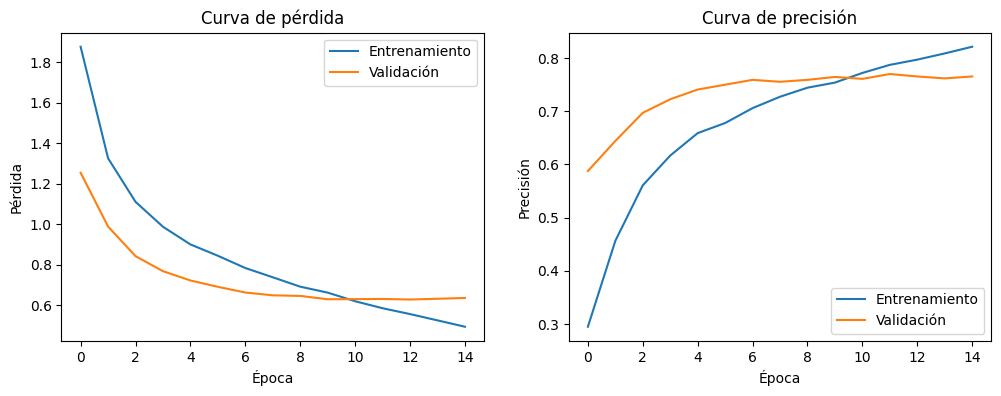

In [83]:
import matplotlib.pyplot as plt


train_loss = history10.history['loss']
val_loss = history10.history['val_loss']
train_accuracy = history10.history['accuracy']
val_accuracy = history10.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Model 9 Bert + Ngram CNN - 64 filters + Dropout each layer

In [84]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(64,2,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_1 = tf.keras.layers.Dropout(0.2)(x_1)
x_2 = tf.keras.layers.Conv1D(64,3,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_2 = tf.keras.layers.Dropout(0.2)(x_2)
x_3 = tf.keras.layers.Conv1D(64,4,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
x_3 = tf.keras.layers.Dropout(0.2)(x_3)
x_4 = tf.keras.layers.Conv1D(64,5,padding='same', activation='relu')(bert_output)
x_4 = tf.keras.layers.GlobalMaxPooling1D()(x_4)
x_4 = tf.keras.layers.Dropout(0.2)(x_4)
merged = tf.concat([x_1,x_2,x_3,x_4], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
model11 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model11.layers[2].trainable=False

model11.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
model11.summary()

history11 = model11.fit(
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=15,
    callbacks = [early_stopping], batch_size=128, shuffle=True
)

print(model11.evaluate([input_ids_test, attention_mask_test], labels_test))

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_29 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_28[0][0]',               
                                thPoolingAndCrossAt               'input_29[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                        

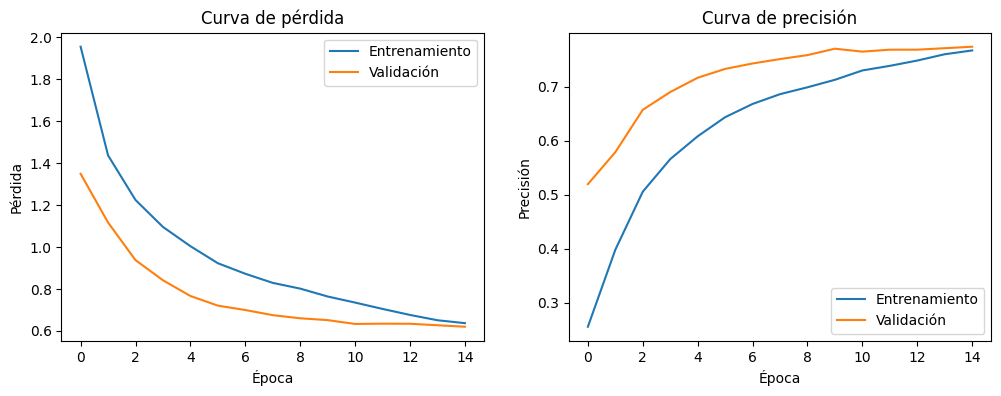

In [85]:
import matplotlib.pyplot as plt


train_loss = history11.history['loss']
val_loss = history11.history['val_loss']
train_accuracy = history11.history['accuracy']
val_accuracy = history11.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Model 10 Bert + Ngram CNN - 128 filters + Dropout each layer

In [86]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_1 = tf.keras.layers.Dropout(0.2)(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_2 = tf.keras.layers.Dropout(0.2)(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
x_3 = tf.keras.layers.Dropout(0.2)(x_3)
x_4 = tf.keras.layers.Conv1D(128,5,padding='same', activation='relu')(bert_output)
x_4 = tf.keras.layers.GlobalMaxPooling1D()(x_4)
x_4 = tf.keras.layers.Dropout(0.2)(x_4)
merged = tf.concat([x_1,x_2,x_3,x_4], axis=-1)
dropout = tf.keras.layers.Dropout(0.4)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
model12 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model12.layers[2].trainable=False

model12.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
model12.summary()

history12 = model12.fit(
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=15,
    callbacks = [early_stopping], batch_size=128, shuffle=True
)

print(model12.evaluate([input_ids_test, attention_mask_test], labels_test))

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_31 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_30[0][0]',               
                                thPoolingAndCrossAt               'input_31[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                        

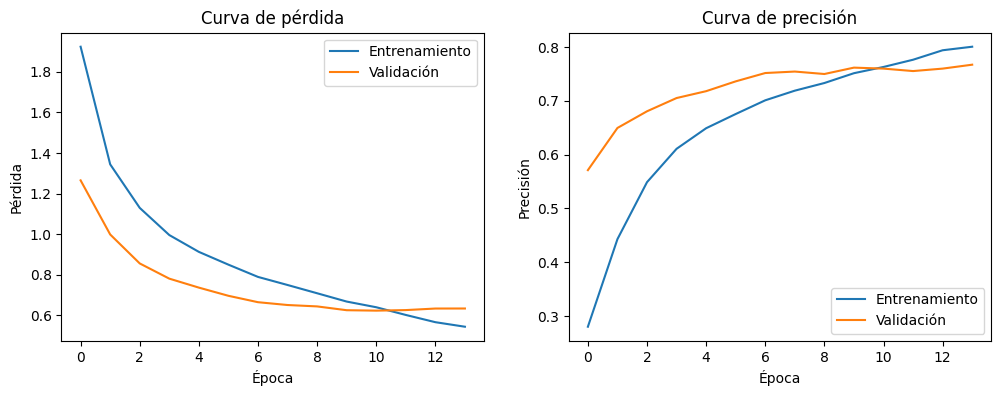

In [87]:
import matplotlib.pyplot as plt


train_loss = history12.history['loss']
val_loss = history12.history['val_loss']
train_accuracy = history12.history['accuracy']
val_accuracy = history12.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Model 11 Bert + Ngram CNN - 32 filters + Dropout each layer - 4 layers

In [88]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(32,2,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_1 = tf.keras.layers.Dropout(0.2)(x_1)
x_2 = tf.keras.layers.Conv1D(32,3,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_2 = tf.keras.layers.Dropout(0.2)(x_2)
x_3 = tf.keras.layers.Conv1D(32,4,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
x_3 = tf.keras.layers.Dropout(0.2)(x_3)
x_4 = tf.keras.layers.Conv1D(32,5,padding='same', activation='relu')(bert_output)
x_4 = tf.keras.layers.GlobalMaxPooling1D()(x_4)
x_4 = tf.keras.layers.Dropout(0.2)(x_4)
merged = tf.concat([x_1,x_2,x_3,x_4], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
model13 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model13.layers[2].trainable=False

model13.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
model13.summary()

history13 = model13.fit(
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=20,
    callbacks = [early_stopping], batch_size=128, shuffle=True
)

print(model13.evaluate([input_ids_test, attention_mask_test], labels_test))

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_32 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_33 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_32[0][0]',               
                                thPoolingAndCrossAt               'input_33[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                        

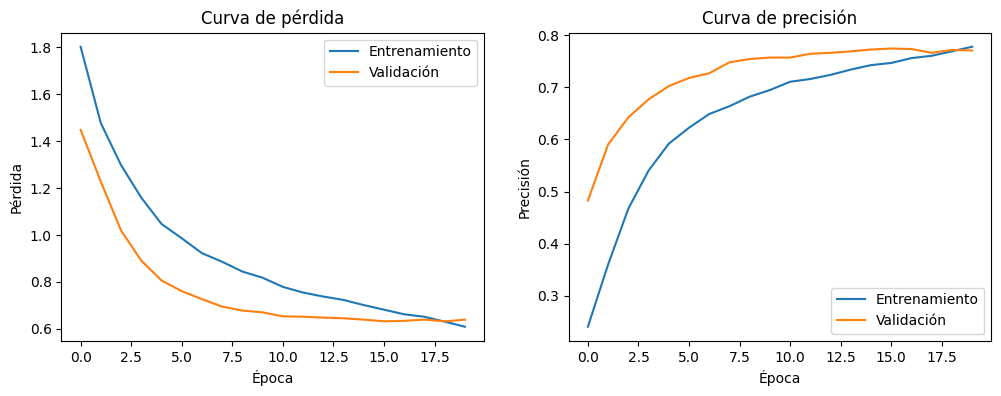

In [89]:
import matplotlib.pyplot as plt


train_loss = history13.history['loss']
val_loss = history13.history['val_loss']
train_accuracy = history13.history['accuracy']
val_accuracy = history13.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Model 12 Bert + Ngram CNN - 128 filters - 128 batch_size - Other learning rate (1e-5)

In [98]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
model18 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model18.layers[2].trainable=False

model18.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
model18.summary()

history18 = model18.fit(
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=20,
    callbacks = [early_stopping], batch_size=128, shuffle=True
)

print(model18.evaluate([input_ids_test, attention_mask_test], labels_test))

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_42 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_43 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_42[0][0]',               
                                thPoolingAndCrossAt               'input_43[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                        

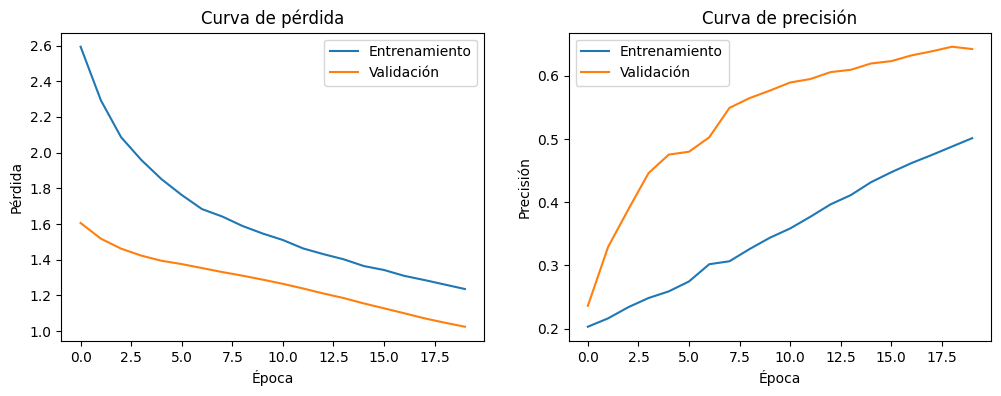

In [99]:
import matplotlib.pyplot as plt


train_loss = history18.history['loss']
val_loss = history18.history['val_loss']
train_accuracy = history18.history['accuracy']
val_accuracy = history18.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Model 13 Bert + Ngram CNN - 32 filters - Other learning rate (1e-5)

In [105]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(32,2,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(32,3,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(32,4,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
model19 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model19.layers[2].trainable=False

model19.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
model19.summary()



Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_46 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_47 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_46[0][0]',               
                                thPoolingAndCrossAt               'input_47[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                        

In [106]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/CNN/64batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/CNN/64batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/CNN/64batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/CNN/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [107]:
history19 = model19.fit(
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=50,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=64
)

print(model19.evaluate([input_ids_test, attention_mask_test], labels_test))

Epoch 1/50
240/240 [==============================] - ETA: 0s - loss: 2.0176 - accuracy: 0.2121 - recall_22: 0.0855
Epoch 1: val_accuracy improved from -inf to 0.30931, saving model to model/BERTHugginfFace/CNN/64batch\BERT_CNN_model_best_01_val_0.3093.h5
240/240 [==============================] - 277s 1s/step - loss: 2.0176 - accuracy: 0.2121 - recall_22: 0.0855 - val_loss: 1.5618 - val_accuracy: 0.3093 - val_recall_22: 0.0000e+00
Epoch 2/50
240/240 [==============================] - ETA: 0s - loss: 1.8547 - accuracy: 0.2152 - recall_22: 0.0590
Epoch 2: val_accuracy improved from 0.30931 to 0.37044, saving model to model/BERTHugginfFace/CNN/64batch\BERT_CNN_model_best_02_val_0.3704.h5
240/240 [==============================] - 340s 1s/step - loss: 1.8547 - accuracy: 0.2152 - recall_22: 0.0590 - val_loss: 1.5320 - val_accuracy: 0.3704 - val_recall_22: 0.0000e+00
Epoch 3/50
240/240 [==============================] - ETA: 0s - loss: 1.7389 - accuracy: 0.2355 - recall_22: 0.0453
Epoch 3: 

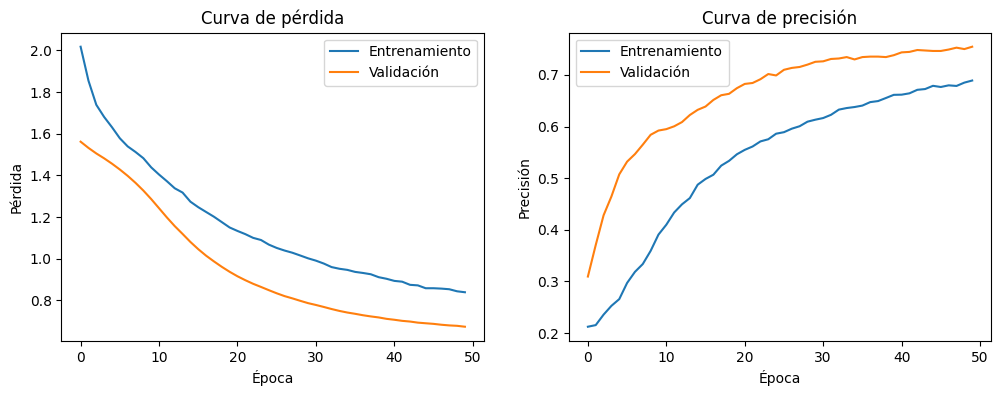

In [108]:
import matplotlib.pyplot as plt


train_loss = history19.history['loss']
val_loss = history19.history['val_loss']
train_accuracy = history19.history['accuracy']
val_accuracy = history19.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Model 14 Bert + Ngram CNN - 100 filters

In [112]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(100,2,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(100,3,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(100,4,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
model21 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model21.layers[2].trainable=False

model21.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
model21.summary()


Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_50 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_51 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_50[0][0]',               
                                thPoolingAndCrossAt               'input_51[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                        

In [113]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/CNN3/64batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/CNN3/64batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/CNN3/64batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/CNN3/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [114]:
history21 = model21.fit(
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=15,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=32, shuffle=True
)


Epoch 1/15
479/479 [==============================] - ETA: 0s - loss: 1.6183 - accuracy: 0.3454 - recall_24: 0.1333
Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to model/BERTHugginfFace/CNN3/64batch\BERT_CNN_model_best_01_val_0.6250.h5
479/479 [==============================] - 252s 507ms/step - loss: 1.6183 - accuracy: 0.3454 - recall_24: 0.1333 - val_loss: 1.0514 - val_accuracy: 0.6250 - val_recall_24: 0.2746
Epoch 2/15
479/479 [==============================] - ETA: 0s - loss: 1.1150 - accuracy: 0.5541 - recall_24: 0.3598
Epoch 2: val_accuracy improved from 0.62500 to 0.70438, saving model to model/BERTHugginfFace/CNN3/64batch\BERT_CNN_model_best_02_val_0.7044.h5
479/479 [==============================] - 239s 499ms/step - loss: 1.1150 - accuracy: 0.5541 - recall_24: 0.3598 - val_loss: 0.8046 - val_accuracy: 0.7044 - val_recall_24: 0.5547
Epoch 3/15
479/479 [==============================] - ETA: 0s - loss: 0.9176 - accuracy: 0.6456 - recall_24: 0.5137
Epoch 3: 

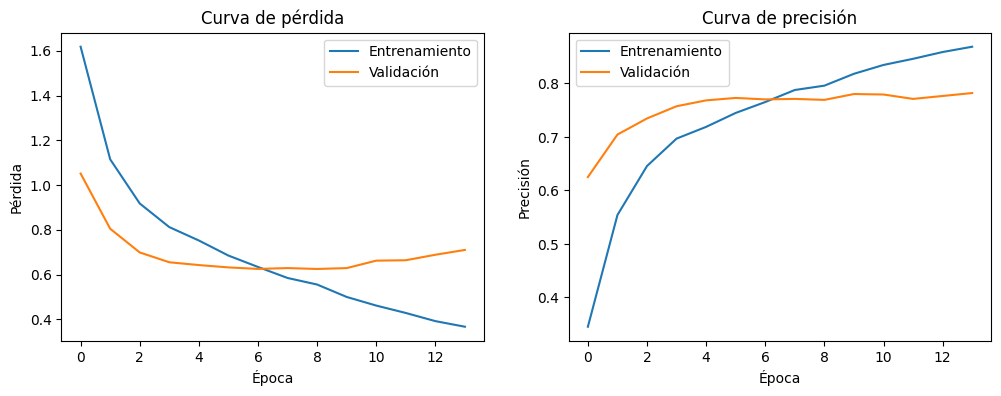

In [121]:
import matplotlib.pyplot as plt


train_loss = history21.history['loss']
val_loss = history21.history['val_loss']
train_accuracy = history21.history['accuracy']
val_accuracy = history21.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Model 15 Bert + CNN + N Gram (128 filters) - 128 batch_size (mejor encontrado bert 78% testeo)

In [125]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
model24 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model24.layers[2].trainable=False

model24.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
model24.summary()



Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_58 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_59 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_58[0][0]',               
                                thPoolingAndCrossAt               'input_59[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                        

In [126]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/Test2/64batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/Test2/64batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/Test2/64batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/Test2/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

#--------------------------------------------------------------------------------
history24 = model24.fit(
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=15,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=128, shuffle=True
)


#print(model23.evaluate([input_ids_test, attention_mask_test], labels_test))

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/15
120/120 [==============================] - ETA: 0s - loss: 1.9517 - accuracy: 0.2659 - recall_28: 0.1161
Epoch 1: val_accuracy improved from -inf to 0.57573, saving model to model/BERTHugginfFace/Test2/64batch\BERT_CNN_model_best_01_val_0.5757.h5
120/120 [==============================] - 337s 3s/step - loss: 1.9517 - accuracy: 0.2659 - recall_28: 0.1161 - val_loss: 1.2966 - val_accuracy: 0.5757 - val_recall_28: 0.0374
Epoch 2/15
120/120 [==============================] - ETA: 0s - loss: 1.3871 - accuracy: 0.4180 - recall_28: 0.1688
Epoch 2: val_accuracy improved from 0.57573 to 0.64325, saving model to model/BERTHugginfFace/Test2/64batch\BERT_CNN_model_best_02_val_0.6432.h5
120/120 [==============================] - 318s 3s/step - loss: 1.3871 - accuracy: 0.4180 - recall_28: 0.1688 - val_loss: 1.0463 - val_accuracy: 0.6432 - val_recall_28: 0.2746
Epoch 3/15
120/120 [===================

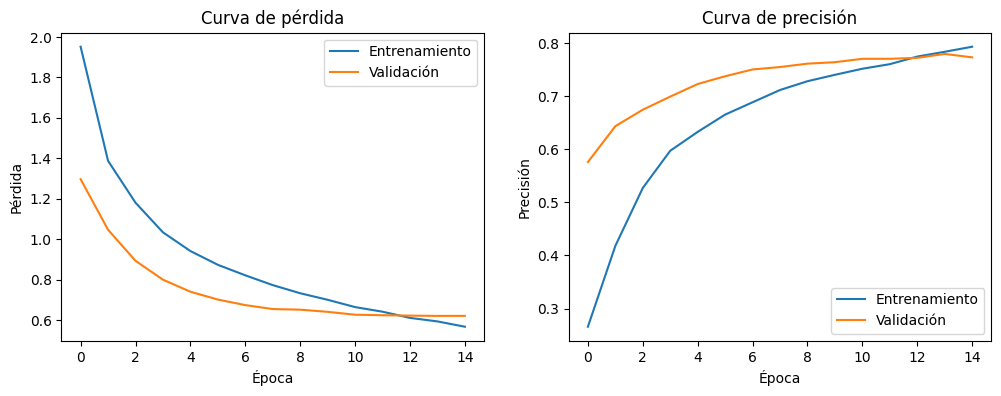

In [127]:
import matplotlib.pyplot as plt


train_loss = history24.history['loss']
val_loss = history24.history['val_loss']
train_accuracy = history24.history['accuracy']
val_accuracy = history24.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [15]:
def custom_objects_fn():
    return {'TFBertModel':TFBertModel}

model_load = load_model(r'model\BERTHugginfFace\Test2\64batch\BERT_CNN_model_best_14_val_0.7792.h5', custom_objects=custom_objects_fn())
model_load.summary()

Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_58 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_59 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_58[0][0]',               
                                thPoolingAndCrossAt               'input_59[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                        

In [151]:
model_load.evaluate([input_ids_test, attention_mask_test], labels_test)

18/18 [==============================] - 11s 399ms/step - loss: 0.6314 - accuracy: 0.7810 - recall_28: 0.7135


[0.6314436793327332, 0.7810218930244446, 0.7135036587715149]

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
y_true  = np.argmax(labels_test, axis=-1)
y_pred = model_load.predict([input_ids_test, attention_mask_test])
y_pred = np.argmax(y_pred, axis=-1)

report = classification_report(y_true,y_pred)
print(report)

matrix = confusion_matrix(y_true,y_pred)
print(matrix)





18/18 [==============================] - 7s 388ms/step
              precision    recall  f1-score   support

           0       0.72      0.69      0.70       110
           1       0.70      0.66      0.68       110
           2       0.86      0.88      0.87       109
           3       0.88      0.91      0.90       109
           4       0.74      0.76      0.75       110

    accuracy                           0.78       548
   macro avg       0.78      0.78      0.78       548
weighted avg       0.78      0.78      0.78       548

[[76 20  2  4  8]
 [19 73  6  3  9]
 [ 4  1 96  2  6]
 [ 0  2  2 99  6]
 [ 7  9  6  4 84]]


In [22]:
np.unique(y_true)

array([0, 1, 2, 3, 4], dtype=int64)

Text(95.72222222222221, 0.5, 'True')

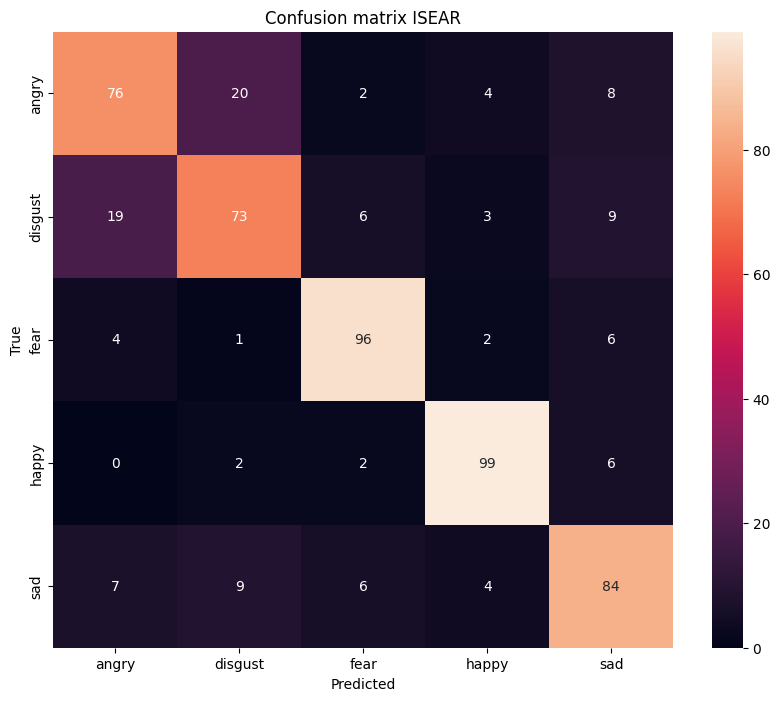

In [24]:
plt.figure(figsize=(10,8))

class_names = ['angry','disgust','fear','happy','sad']

sns.heatmap(matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion matrix ISEAR')
plt.xlabel('Predicted')
plt.ylabel('True')

### Model 16 Bert + CNN + N Gram (128 filters) - 64 batch_size

In [128]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
model25 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model25.layers[2].trainable=False

model25.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
model25.summary()



Model: "model_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_60 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_61 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_60[0][0]',               
                                thPoolingAndCrossAt               'input_61[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                        

In [129]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/Test3/64batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/Test3/64batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/Test3/64batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/Test3/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

#--------------------------------------------------------------------------------
history25 = model25.fit(
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=15,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=64, shuffle=True
)

#print(model23.evaluate([input_ids_test, attention_mask_test], labels_test))

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/15
240/240 [==============================] - ETA: 0s - loss: 1.7041 - accuracy: 0.3096 - recall_29: 0.1169
Epoch 1: val_accuracy improved from -inf to 0.59763, saving model to model/BERTHugginfFace/Test3/64batch\BERT_CNN_model_best_01_val_0.5976.h5
240/240 [==============================] - 343s 1s/step - loss: 1.7041 - accuracy: 0.3096 - recall_29: 0.1169 - val_loss: 1.1839 - val_accuracy: 0.5976 - val_recall_29: 0.1387
Epoch 2/15
240/240 [==============================] - ETA: 0s - loss: 1.2290 - accuracy: 0.5034 - recall_29: 0.2716
Epoch 2: val_accuracy improved from 0.59763 to 0.67427, saving model to model/BERTHugginfFace/Test3/64batch\BERT_CNN_model_best_02_val_0.6743.h5
240/240 [==============================] - 324s 1s/step - loss: 1.2290 - accuracy: 0.5034 - recall_29: 0.2716 - val_loss: 0.8950 - val_accuracy: 0.6743 - val_recall_29: 0.4535
Epoch 3/15
240/240 [===================

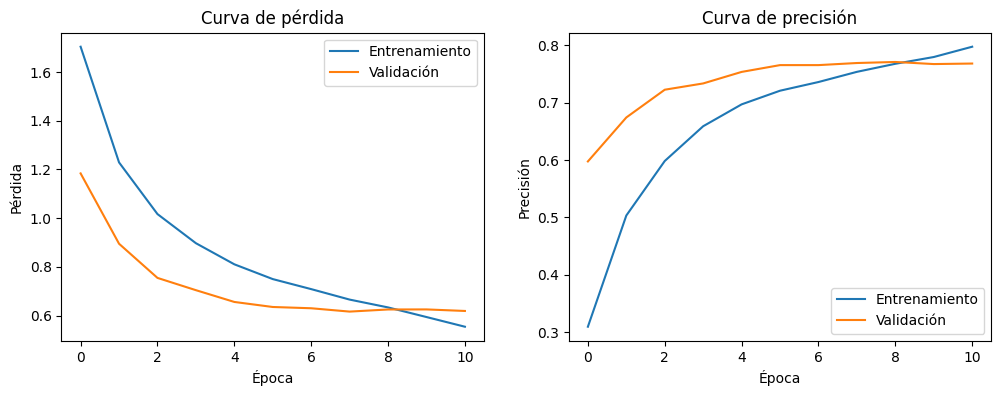

In [130]:
import matplotlib.pyplot as plt


train_loss = history25.history['loss']
val_loss = history25.history['val_loss']
train_accuracy = history25.history['accuracy']
val_accuracy = history25.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Model 17 Bert + CNN + N Gram (128 filters) - 32 batch_size

In [131]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
model26 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model26.layers[2].trainable=False

model26.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
model26.summary()


Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_62 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_63 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_62[0][0]',               
                                thPoolingAndCrossAt               'input_63[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                        

In [132]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/Test4/64batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/Test4/64batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/Test4/64batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/Test4/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

#--------------------------------------------------------------------------------
history26 = model26.fit(
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=15,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=32, shuffle=True
)

#print(model23.evaluate([input_ids_test, attention_mask_test], labels_test))

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/15
479/479 [==============================] - ETA: 0s - loss: 1.6063 - accuracy: 0.3481 - recall_30: 0.1517
Epoch 1: val_accuracy improved from -inf to 0.61405, saving model to model/BERTHugginfFace/Test4/64batch\BERT_CNN_model_best_01_val_0.6141.h5
479/479 [==============================] - 324s 662ms/step - loss: 1.6063 - accuracy: 0.3481 - recall_30: 0.1517 - val_loss: 1.0418 - val_accuracy: 0.6141 - val_recall_30: 0.3148
Epoch 2/15
479/479 [==============================] - ETA: 0s - loss: 1.0980 - accuracy: 0.5647 - recall_30: 0.3808
Epoch 2: val_accuracy improved from 0.61405 to 0.70255, saving model to model/BERTHugginfFace/Test4/64batch\BERT_CNN_model_best_02_val_0.7026.h5
479/479 [==============================] - 314s 654ms/step - loss: 1.0980 - accuracy: 0.5647 - recall_30: 0.3808 - val_loss: 0.7871 - val_accuracy: 0.7026 - val_recall_30: 0.5794
Epoch 3/15
479/479 [=============

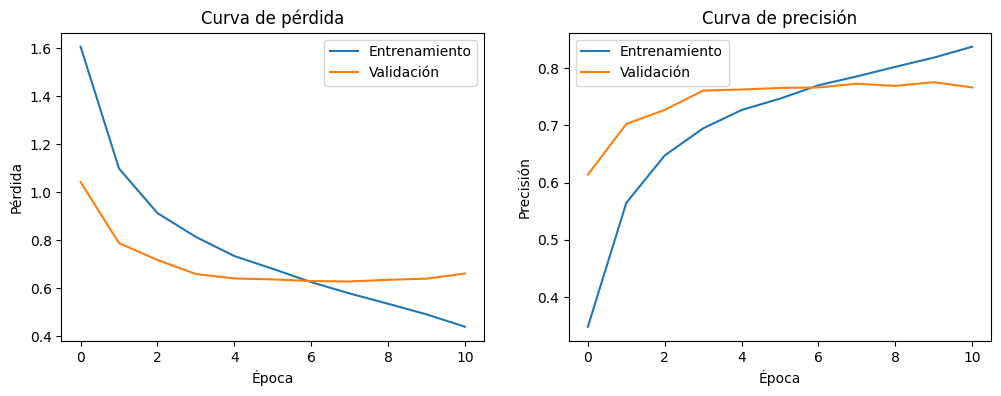

In [133]:
import matplotlib.pyplot as plt


train_loss = history26.history['loss']
val_loss = history26.history['val_loss']
train_accuracy = history26.history['accuracy']
val_accuracy = history26.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Model 18 Bert + CNN + N Gram (256 filters) - 64 batch_size - Repeat 1 layer

In [143]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(256,2,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(256,3,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(256,3,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
model28 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model28.layers[2].trainable=False

model28.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
model28.summary()


Model: "model_39"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_70 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_71 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_70[0][0]',               
                                thPoolingAndCrossAt               'input_71[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                        

In [144]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/Test6/64batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/Test6/64batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/Test6/64batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/Test6/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

#--------------------------------------------------------------------------------
history28 = model28.fit(
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=15,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=64, shuffle=True
)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/15
240/240 [==============================] - ETA: 0s - loss: 1.7580 - accuracy: 0.3096 - recall_34: 0.1249
Epoch 1: val_accuracy improved from -inf to 0.59307, saving model to model/BERTHugginfFace/Test6/64batch\BERT_CNN_model_best_01_val_0.5931.h5
240/240 [==============================] - 347s 1s/step - loss: 1.7580 - accuracy: 0.3096 - recall_34: 0.1249 - val_loss: 1.2419 - val_accuracy: 0.5931 - val_recall_34: 0.0912
Epoch 2/15
240/240 [==============================] - ETA: 0s - loss: 1.2497 - accuracy: 0.4894 - recall_34: 0.2764
Epoch 2: val_accuracy improved from 0.59307 to 0.65785, saving model to model/BERTHugginfFace/Test6/64batch\BERT_CNN_model_best_02_val_0.6578.h5
240/240 [==============================] - 330s 1s/step - loss: 1.2497 - accuracy: 0.4894 - recall_34: 0.2764 - val_loss: 0.9104 - val_accuracy: 0.6578 - val_recall_34: 0.4279
Epoch 3/15
240/240 [===================

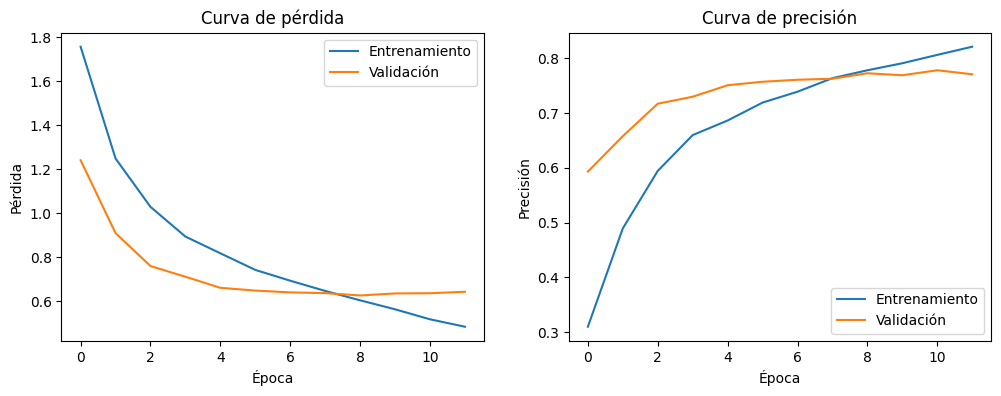

In [145]:
import matplotlib.pyplot as plt


train_loss = history28.history['loss']
val_loss = history28.history['val_loss']
train_accuracy = history28.history['accuracy']
val_accuracy = history28.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [152]:
def custom_objects_fn():
    return {'TFBertModel':TFBertModel}

model_load2 = load_model(r'model\BERTHugginfFace\Test6\64batch\BERT_CNN_model_best_11_val_0.7783.h5', custom_objects=custom_objects_fn())
model_load2.summary()

Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


Model: "model_39"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_70 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_71 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_3 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_70[0][0]',               
                                thPoolingAndCrossAt               'input_71[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                        

In [153]:
model_load2.evaluate([input_ids_test, attention_mask_test], labels_test)

18/18 [==============================] - 11s 402ms/step - loss: 0.6580 - accuracy: 0.7774 - recall_34: 0.7263


[0.6580227017402649, 0.7773722410202026, 0.7262773513793945]

### Model 19 Bert + CNN + N Gram (256 filters) - 64 batch_size

In [146]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(256,2,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(256,3,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(256,4,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(256, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
model29 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model29.layers[2].trainable=False

model29.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
model29.summary()

Model: "model_40"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_72 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_73 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_72[0][0]',               
                                thPoolingAndCrossAt               'input_73[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                        

In [147]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/Test7/64batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/Test7/64batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/Test7/64batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/Test7/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

#--------------------------------------------------------------------------------
history29 = model29.fit(
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=15,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=64, shuffle=True
)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/15
240/240 [==============================] - ETA: 0s - loss: 1.7304 - accuracy: 0.3025 - recall_35: 0.1010
Epoch 1: val_accuracy improved from -inf to 0.58303, saving model to model/BERTHugginfFace/Test7/64batch\BERT_CNN_model_best_01_val_0.5830.h5
240/240 [==============================] - 347s 1s/step - loss: 1.7304 - accuracy: 0.3025 - recall_35: 0.1010 - val_loss: 1.3501 - val_accuracy: 0.5830 - val_recall_35: 0.0155
Epoch 2/15
240/240 [==============================] - ETA: 0s - loss: 1.2782 - accuracy: 0.4720 - recall_35: 0.2457
Epoch 2: val_accuracy improved from 0.58303 to 0.64872, saving model to model/BERTHugginfFace/Test7/64batch\BERT_CNN_model_best_02_val_0.6487.h5
240/240 [==============================] - 330s 1s/step - loss: 1.2782 - accuracy: 0.4720 - recall_35: 0.2457 - val_loss: 0.9615 - val_accuracy: 0.6487 - val_recall_35: 0.3850
Epoch 3/15
240/240 [===================

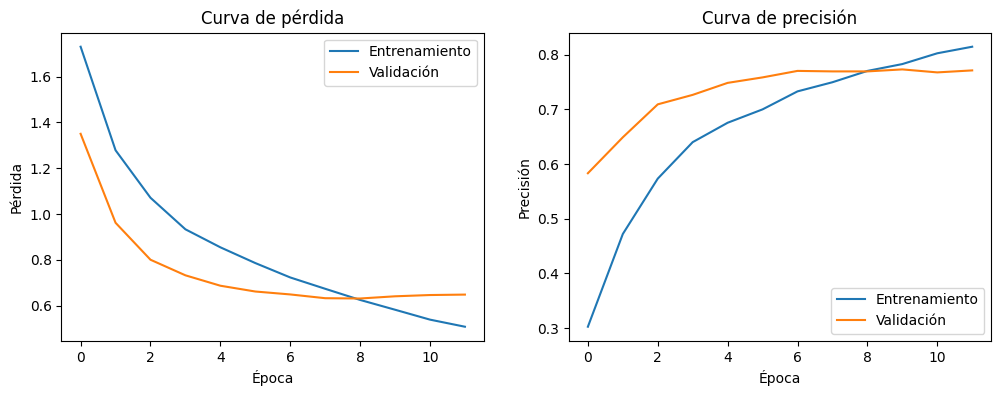

In [148]:
import matplotlib.pyplot as plt


train_loss = history29.history['loss']
val_loss = history29.history['val_loss']
train_accuracy = history29.history['accuracy']
val_accuracy = history29.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

## Models test with Roberta best model

### 128 batch (mejor encontrado 79% testeo)

In [37]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
roberta_output = roberta_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(roberta_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(roberta_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(roberta_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
modelTestRoberta = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

modelTestRoberta.layers[2].trainable=False

modelTestRoberta.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
modelTestRoberta.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_5[0][0]',                
 el)                            thPoolingAndCrossAt               'input_6[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [38]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/128batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/128batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/128batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/128batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

#--------------------------------------------------------------------------------
historyRoberta = modelTestRoberta.fit(
    [input_ids_train_roberta, attention_mask_train_roberta], labels_train_roberta,
    validation_data=([input_ids_val_roberta, attention_mask_val_roberta], labels_val_roberta),
    epochs=20,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=128, shuffle=True
)


#print(model23.evaluate([input_ids_test, attention_mask_test], labels_test))

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/20
120/120 [==============================] - ETA: 0s - loss: 2.0542 - accuracy: 0.2339 - recall_2: 0.0989
Epoch 1: val_accuracy improved from -inf to 0.46350, saving model to model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/128batch\BERT_CNN_model_best_01_val_0.4635.h5
120/120 [==============================] - 287s 2s/step - loss: 2.0542 - accuracy: 0.2339 - recall_2: 0.0989 - val_loss: 1.5088 - val_accuracy: 0.4635 - val_recall_2: 0.0000e+00
Epoch 2/20
120/120 [==============================] - ETA: 0s - loss: 1.6049 - accuracy: 0.2943 - recall_2: 0.0463
Epoch 2: val_accuracy improved from 0.46350 to 0.53011, saving model to model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/128batch\BERT_CNN_model_best_02_val_0.5301.h5
120/120 [==============================] - 257s 2s/step - loss: 1.6049 - accuracy: 0.2943 - recall_2: 0.0463 - val_loss

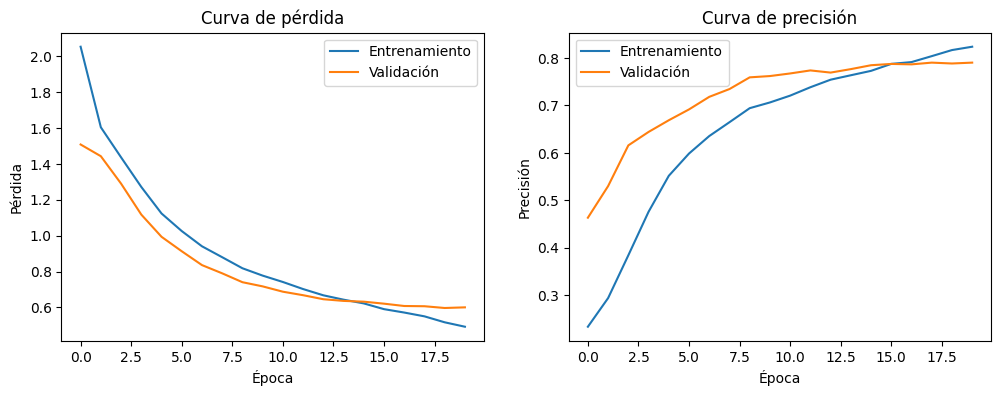

In [39]:
import matplotlib.pyplot as plt


train_loss = historyRoberta.history['loss']
val_loss = historyRoberta.history['val_loss']
train_accuracy = historyRoberta.history['accuracy']
val_accuracy = historyRoberta.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [40]:
modelTestRoberta.evaluate([input_ids_test_roberta, attention_mask_test_roberta], labels_test_roberta)

18/18 [==============================] - 11s 573ms/step - loss: 0.6120 - accuracy: 0.7865 - recall_2: 0.6989


[0.6119632124900818, 0.7864963412284851, 0.6989051103591919]

In [43]:
modelTestRoberta.save('model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/128batch/BERT_CNN_model_best_20_val_0.7901_best.h5')

In [46]:
from sklearn.metrics import classification_report, confusion_matrix
y_true  = np.argmax(labels_test, axis=-1)
y_pred = modelTestRoberta.predict([input_ids_test_roberta, attention_mask_test_roberta])
y_pred = np.argmax(y_pred, axis=-1)

report = classification_report(y_true,y_pred)
print(report)

matrix = confusion_matrix(y_true,y_pred)
print(matrix)


18/18 [==============================] - 11s 568ms/step
              precision    recall  f1-score   support

           0       0.72      0.77      0.75       110
           1       0.78      0.67      0.72       110
           2       0.84      0.82      0.83       109
           3       0.87      0.93      0.90       109
           4       0.73      0.75      0.74       110

    accuracy                           0.79       548
   macro avg       0.79      0.79      0.79       548
weighted avg       0.79      0.79      0.79       548

[[ 85  15   2   0   8]
 [ 20  74   6   3   7]
 [  3   1  89   6  10]
 [  1   0   1 101   6]
 [  9   5   8   6  82]]


Text(95.72222222222221, 0.5, 'True')

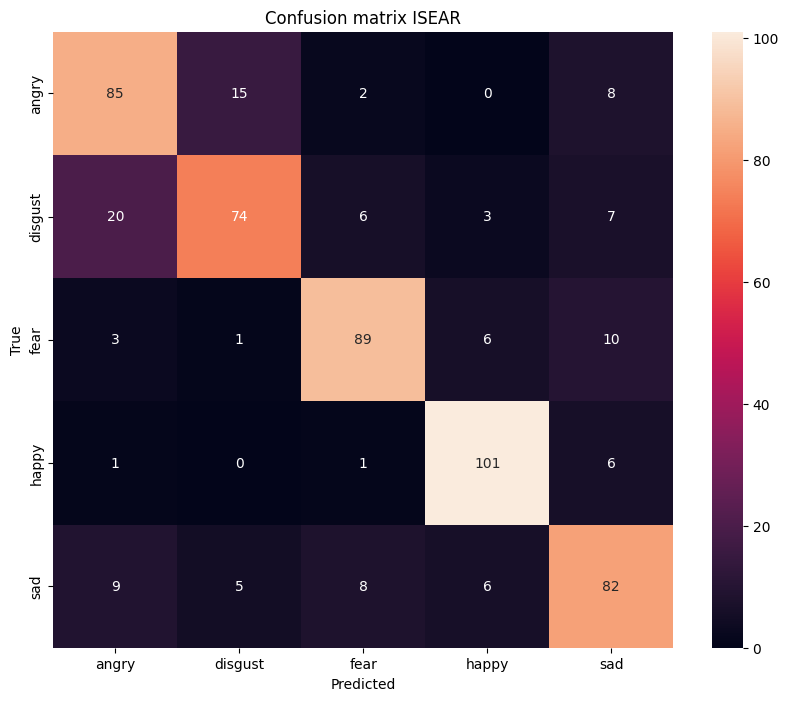

In [47]:
plt.figure(figsize=(10,8))

class_names = ['angry','disgust','fear','happy','sad']

sns.heatmap(matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion matrix ISEAR')
plt.xlabel('Predicted')
plt.ylabel('True')

### 64 batch

In [48]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
roberta_output = roberta_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(roberta_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(roberta_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(roberta_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
modelTestRoberta2 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

modelTestRoberta2.layers[2].trainable=False

modelTestRoberta2.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
modelTestRoberta2.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_7[0][0]',                
 el)                            thPoolingAndCrossAt               'input_8[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [50]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/64batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/64batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/64batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

#--------------------------------------------------------------------------------
historyRoberta2 = modelTestRoberta2.fit(
    [input_ids_train_roberta, attention_mask_train_roberta], labels_train_roberta,
    validation_data=([input_ids_val_roberta, attention_mask_val_roberta], labels_val_roberta),
    epochs=20,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=64, shuffle=True
)


#print(model23.evaluate([input_ids_test, attention_mask_test], labels_test))

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/20
240/240 [==============================] - ETA: 0s - loss: 1.9441 - accuracy: 0.2342 - recall_3: 0.0741
Epoch 1: val_accuracy improved from -inf to 0.45985, saving model to model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/64batch\BERT_CNN_model_best_01_val_0.4599.h5
240/240 [==============================] - 298s 1s/step - loss: 1.9441 - accuracy: 0.2342 - recall_3: 0.0741 - val_loss: 1.5233 - val_accuracy: 0.4599 - val_recall_3: 0.0000e+00
Epoch 2/20
240/240 [==============================] - ETA: 0s - loss: 1.5147 - accuracy: 0.3395 - recall_3: 0.0457
Epoch 2: val_accuracy improved from 0.45985 to 0.58212, saving model to model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/64batch\BERT_CNN_model_best_02_val_0.5821.h5
240/240 [==============================] - 325s 1s/step - loss: 1.5147 - accuracy: 0.3395 - recall_3: 0.0457 - val_loss: 

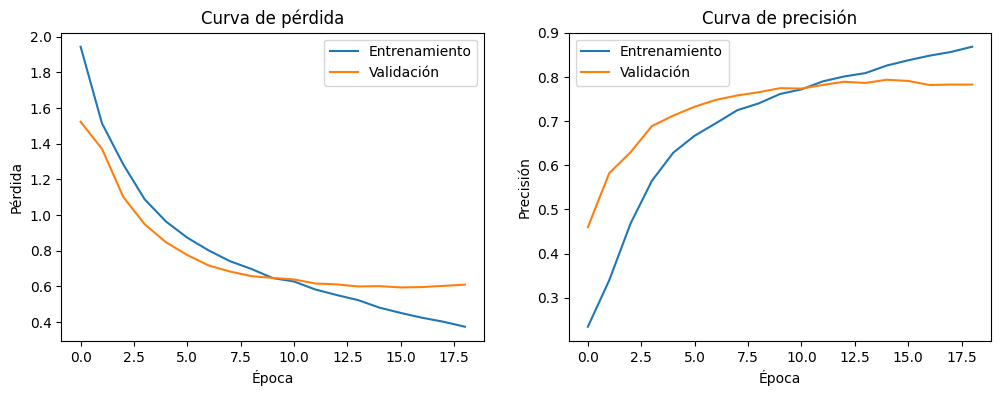

In [51]:
import matplotlib.pyplot as plt


train_loss = historyRoberta2.history['loss']
val_loss = historyRoberta2.history['val_loss']
train_accuracy = historyRoberta2.history['accuracy']
val_accuracy = historyRoberta2.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [43]:
def custom_objects_fn_roberta():
    return {'TFRobertaModel': TFRobertaModel}

model_Roberta564_load = tf.keras.models.load_model('model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/64batch\BERT_CNN_model_best_15_val_0.7938.h5', custom_objects= custom_objects_fn_roberta())
model_Roberta564_load.evaluate([input_ids_test_roberta, attention_mask_test_roberta], labels_test_roberta)

18/18 [==============================] - 11s 393ms/step - loss: 0.6108 - accuracy: 0.7774 - recall_3: 0.7080


[0.6108262538909912, 0.7773722410202026, 0.7080292105674744]

### 32 batch

In [52]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
roberta_output = roberta_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(roberta_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(roberta_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(roberta_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
modelTestRoberta3 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

modelTestRoberta3.layers[2].trainable=False

modelTestRoberta3.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
modelTestRoberta3.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_9[0][0]',                
 el)                            thPoolingAndCrossAt               'input_10[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [53]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/32batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/32batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/32batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/32batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

#--------------------------------------------------------------------------------
historyRoberta3 = modelTestRoberta3.fit(
    [input_ids_train_roberta, attention_mask_train_roberta], labels_train_roberta,
    validation_data=([input_ids_val_roberta, attention_mask_val_roberta], labels_val_roberta),
    epochs=20,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=32, shuffle=True
)


#print(model23.evaluate([input_ids_test, attention_mask_test], labels_test))

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/20
479/479 [==============================] - ETA: 0s - loss: 1.7879 - accuracy: 0.2623 - recall_4: 0.0652
Epoch 1: val_accuracy improved from -inf to 0.54471, saving model to model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/32batch\BERT_CNN_model_best_01_val_0.5447.h5
479/479 [==============================] - 349s 701ms/step - loss: 1.7879 - accuracy: 0.2623 - recall_4: 0.0652 - val_loss: 1.4194 - val_accuracy: 0.5447 - val_recall_4: 0.0000e+00
Epoch 2/20
479/479 [==============================] - ETA: 0s - loss: 1.3153 - accuracy: 0.4514 - recall_4: 0.1637
Epoch 2: val_accuracy improved from 0.54471 to 0.64872, saving model to model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/32batch\BERT_CNN_model_best_02_val_0.6487.h5
479/479 [==============================] - 331s 691ms/step - loss: 1.3153 - accuracy: 0.4514 - recall_4: 0.1637 - val_

In [55]:
load_model3 = load_model(r'model\BERTHugginfFace\OptimizationBestModel\OptimizationBestModel_roberta3\32batch\BERT_CNN_model_best_11_val_0.7965.h5', custom_objects=custom_objects_fn_roberta())
load_model3.summary()

load_model3.evaluate([input_ids_test_roberta, attention_mask_test_roberta], labels_test_roberta)

Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_roberta_model_3 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_9[0][0]',                
 odel)                          thPoolingAndCrossAt               'input_10[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

[0.6084970235824585, 0.7700729966163635, 0.709854006767273]

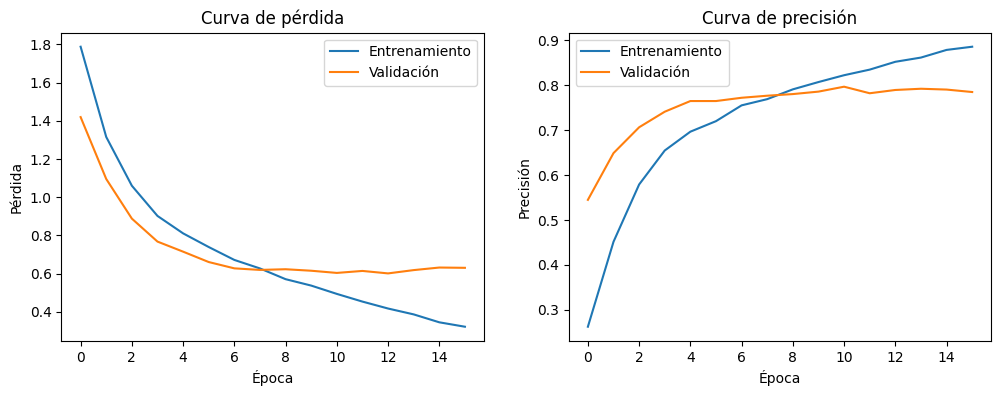

In [54]:
import matplotlib.pyplot as plt


train_loss = historyRoberta3.history['loss']
val_loss = historyRoberta3.history['val_loss']
train_accuracy = historyRoberta3.history['accuracy']
val_accuracy = historyRoberta3.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### 128 batch with more dropout

In [16]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
roberta_output = roberta_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(roberta_output)
x_1 = tf.keras.layers.Dropout(0.2)(x_1)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(roberta_output)
x_2 = tf.keras.layers.Dropout(0.2)(x_2)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(roberta_output)
x_3 = tf.keras.layers.Dropout(0.2)(x_3)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
modelTestRobertaDropout_5emotions = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

modelTestRobertaDropout_5emotions.layers[2].trainable=False

modelTestRobertaDropout_5emotions.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
modelTestRobertaDropout_5emotions.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                           

In [17]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/128batchWithDropout', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/128batchWithDropout/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/128batchWithDropout', exist_ok=True)



log_dir = "logs/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/128batchWithDropout" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

#--------------------------------------------------------------------------------
historyRobertaDropout_5emotions = modelTestRobertaDropout_5emotions.fit(
    [input_ids_train_roberta, attention_mask_train_roberta], labels_train_roberta,
    validation_data=([input_ids_val_roberta, attention_mask_val_roberta], labels_val_roberta),
    epochs=20,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=128, shuffle=True
)


#print(model23.evaluate([input_ids_test, attention_mask_test], labels_test))

Epoch 1/20
120/120 [==============================] - ETA: 0s - loss: 2.2777 - accuracy: 0.2224 - recall: 0.1186
Epoch 1: val_accuracy improved from -inf to 0.42153, saving model to model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/128batchWithDropout\BERT_CNN_model_best_01_val_0.4215.h5
120/120 [==============================] - 290s 2s/step - loss: 2.2777 - accuracy: 0.2224 - recall: 0.1186 - val_loss: 1.5319 - val_accuracy: 0.4215 - val_recall: 0.0000e+00
Epoch 2/20
120/120 [==============================] - ETA: 0s - loss: 1.6426 - accuracy: 0.2780 - recall: 0.0557
Epoch 2: val_accuracy improved from 0.42153 to 0.52372, saving model to model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/128batchWithDropout\BERT_CNN_model_best_02_val_0.5237.h5
120/120 [==============================] - 258s 2s/step - loss: 1.6426 - accuracy: 0.2780 - recall: 0.0557 - val_loss: 1.5010 - val_accuracy: 0.5237 - val_recall: 0.0000e+00
Epoch 3/20
120/120 [=

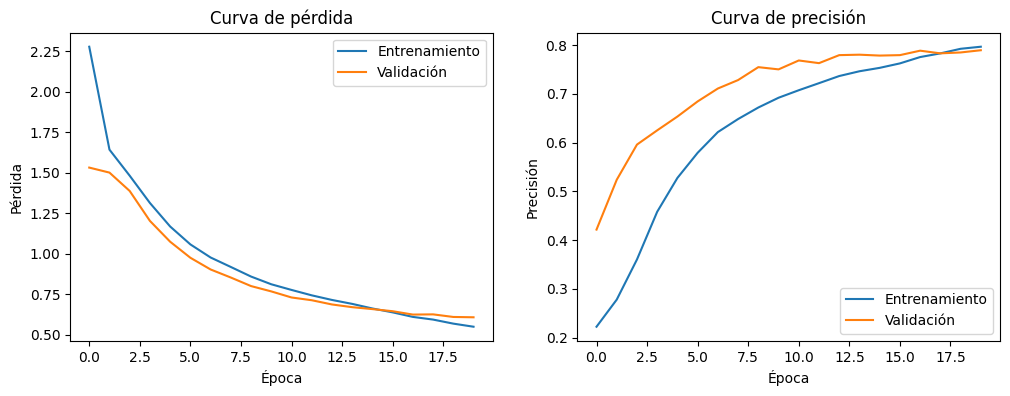

In [18]:
import matplotlib.pyplot as plt


train_loss = historyRobertaDropout_5emotions.history['loss']
val_loss = historyRobertaDropout_5emotions.history['val_loss']
train_accuracy = historyRobertaDropout_5emotions.history['accuracy']
val_accuracy = historyRobertaDropout_5emotions.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [24]:
modelTestRobertaDropout_5emotions.evaluate([input_ids_test_roberta, attention_mask_test_roberta], labels_test_roberta)

18/18 [==============================] - 7s 397ms/step - loss: 0.6233 - accuracy: 0.7664 - recall: 0.6642


[0.6233377456665039, 0.7664233446121216, 0.6642335653305054]

# With 7 Emotions

## Seed definition

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = "1"
    os.environ['TF_CUDNN_DETERMINISM'] = "1"
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

## Isear dataset

In [5]:
isear = pd.read_excel('ISEAR.xlsx')


print(isear.head())

      ID  CITY  COUN  SUBJ  SEX  AGE  RELI  PRAC  FOCC  MOCC  ...  SELF  RELA  \
0  11001     1     1     1    1   33     1     2     6     1  ...     3     3   
1  11001     1     1     1    1   33     1     2     6     1  ...     2     2   
2  11001     1     1     1    1   33     1     2     6     1  ...     2     1   
3  11001     1     1     1    1   33     1     2     6     1  ...     1     1   
4  11001     1     1     1    1   33     1     2     6     1  ...     0     2   

   VERBAL  NEUTRO   Field1  Field3  Field2   MYKEY  \
0       2       0      joy       4       3  110011   
1       0       0     fear       3       2  110012   
2       0       0    anger       1       3  110013   
3       0       2  sadness       4       4  110014   
4       0       0  disgust       4       4  110015   

                                                 SIT  STATE  
0  During the period of falling in love, each tim...      1  
1         When I was involved in a traffic accident.      1  
2 

In [6]:
isearDataset = isear.iloc[:, [40,36]]
isearDataset = isearDataset.rename(columns={'Field1': 'label', 'SIT': 'texto'})
isearDataset

,texto,label
0,"During the period of falling in love, each tim...",joy
1,When I was involved in a traffic accident.,fear
2,When I was driving home after several days of...,anger
3,When I lost the person who meant the most to me.,sadness
4,The time I knocked a deer down - the sight of ...,disgust
...,...,...
7661,Two years back someone invited me to be the tu...,anger
7662,I had taken the responsibility to do something...,sadness
7663,I was at home and I heard a loud sound of spit...,disgust
7664,I did not do the homework that the teacher had...,shame


In [7]:
def eliminarAcentos(texto):
    texto = texto.replace('á', '')
    texto = texto.replace('\n', '')
    return texto
isearDataset['texto'] = isearDataset['texto'].apply(eliminarAcentos)

In [8]:
isearDataset = isearDataset.replace(to_replace=['joy', 'anger', 'sadness'], value=['happy', 'angry', 'sad']) #Reemplazar nombres de datos
isearDataset = isearDataset.drop(isearDataset[isearDataset['label']== 'shame'].index) #Eliminar nombres de datos de emociones que no se ocupan
isearDataset = isearDataset.drop(isearDataset[isearDataset['label']== 'guilt'].index)
isearDataset = isearDataset.drop(isearDataset[isearDataset['label']== 'guit'].index)
isearDataset = isearDataset.reset_index(drop=True)
isearDataset

,texto,label
0,"During the period of falling in love, each tim...",happy
1,When I was involved in a traffic accident.,fear
2,When I was driving home after several days of...,angry
3,When I lost the person who meant the most to me.,sad
4,The time I knocked a deer down - the sight of ...,disgust
...,...,...
5472,I received a letter from a distant friend.,happy
5473,My parents were out and I was the eldest at ho...,fear
5474,Two years back someone invited me to be the tu...,angry
5475,I had taken the responsibility to do something...,sad


In [9]:
isearDataset.describe()

,texto,label
count,5477,5477
unique,5384,5
top,[ No response.],angry
freq,42,1096


In [69]:
isearDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5477 entries, 0 to 5476
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texto   5477 non-null   object
 1   label   5477 non-null   object
dtypes: object(2)
memory usage: 85.7+ KB


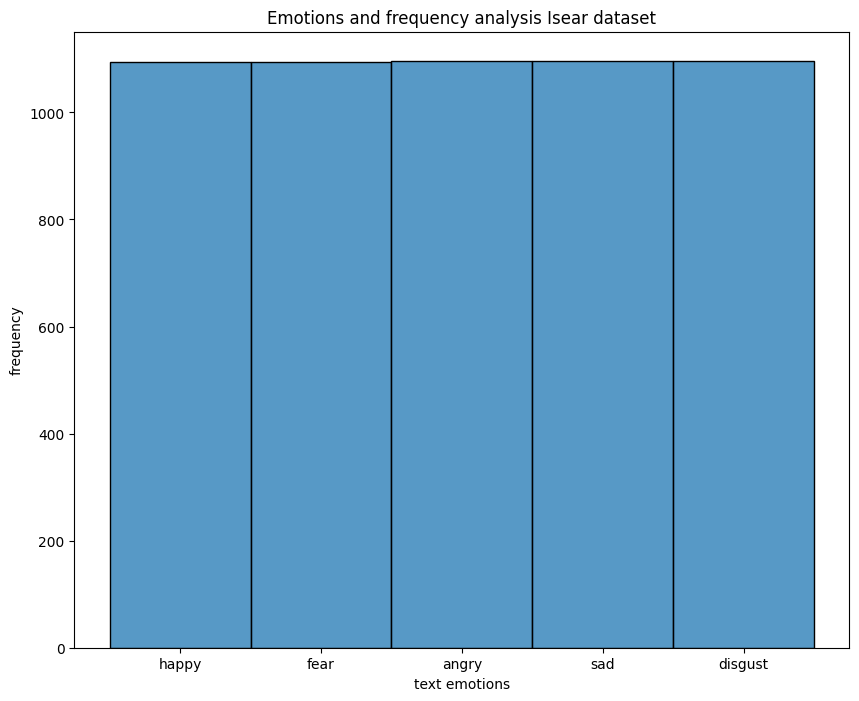

In [71]:
plt.figure(figsize=(10,8))
sns.histplot(isearDataset['label'])
plt.xlabel('text emotions')
plt.ylabel('frequency')
plt.title('Emotions and frequency analysis Isear dataset')
plt.show()

In [72]:
isearDataset['label'].value_counts()


label
angry      1096
sad        1096
disgust    1096
fear       1095
happy      1094
Name: count, dtype: int64

In [73]:
isearDataset['label'].unique()


array(['happy', 'fear', 'angry', 'sad', 'disgust'], dtype=object)

## Meld dataset

In [9]:
dfMeld=pd.read_csv('meld_train.csv')

label = dfMeld['Emotion']
text = dfMeld['Utterance']

data = {
    'texto' : text.tolist(),
    'label' : label.tolist()
}

dfMeld= pd.DataFrame(data)

In [10]:
dfMeld = dfMeld.replace(to_replace=['joy', 'sadness', 'anger'], value=['happy', 'sad', 'angry'])
dfMeld

,texto,label
0,also I was the point person on my companys tr...,neutral
1,You mustve had your hands full.,neutral
2,That I did. That I did.,neutral
3,So lets talk a little bit about your duties.,neutral
4,My duties? All right.,surprise
...,...,...
9984,You or me?,neutral
9985,"I got it. Uh, Joey, women don't have Adam's ap...",neutral
9986,"You guys are messing with me, right?",surprise
9987,Yeah.,neutral


In [11]:
def eliminarAcentos(texto):
    texto = texto.replace('[]', "'")
    texto = texto.replace('', "'")
    return texto
dfMeld['texto'] = dfMeld['texto'].apply(eliminarAcentos)
dfMeld

,texto,label
0,also I was the point person on my company's tr...,neutral
1,You must've had your hands full.,neutral
2,That I did. That I did.,neutral
3,So let's talk a little bit about your duties.,neutral
4,My duties? All right.,surprise
...,...,...
9984,You or me?,neutral
9985,"I got it. Uh, Joey, women don't have Adam's ap...",neutral
9986,"You guys are messing with me, right?",surprise
9987,Yeah.,neutral


## Add Surprise and neutral missing emotions from Meld dataset

In [12]:
dfMeldsurprise = dfMeld[dfMeld['label']=='surprise'].sample(1096, random_state=42)
dfMeldneutral = dfMeld[dfMeld['label']=='neutral'].sample(1096, random_state=42)

In [13]:
dfMeldsurprise.reset_index(inplace=True)
dfMeldsurprise

,index,texto,label
0,874,What the hell is this?!,surprise
1,7741,"Nothing, I'm just practicing blowing you off b...",surprise
2,2506,"Really? My God, he's really cute.",surprise
3,956,No?,surprise
4,8731,Really?,surprise
...,...,...,...
1091,3274,It worked!,surprise
1092,6083,I do?,surprise
1093,9148,What one? You wanted him to invite you to the ...,surprise
1094,8416,No-no!,surprise


In [14]:
dfMeldneutral.reset_index(inplace=True)
dfMeldneutral

,index,texto,label
0,2573,"Now, have you told anyone else?",neutral
1,3677,No.,neutral
2,6939,"No thanks, I've already seen one.",neutral
3,7866,"No, answer his.",neutral
4,7931,"Y'know, twin stuff is always a real big seller.",neutral
...,...,...,...
1091,58,Ameri-can.,neutral
1092,6934,"Hey, so did everything go all right with the a...",neutral
1093,1569,"No,",neutral
1094,9323,Hey.,neutral


## Create dataset 7 emotions

now the dataset has 7 emotions : angry, sad, disgust, neutral, surprise, fear and happy

In [15]:
dftodo = pd.concat([isearDataset, dfMeldneutral, dfMeldsurprise], axis=0, ignore_index=True)
dftodo.reset_index(drop=True, inplace=True)
dftodo.drop('index', axis=1, inplace=True)
dftodo


,texto,label
0,"During the period of falling in love, each tim...",happy
1,When I was involved in a traffic accident.,fear
2,When I was driving home after several days of...,angry
3,When I lost the person who meant the most to me.,sad
4,The time I knocked a deer down - the sight of ...,disgust
...,...,...
7664,It worked!,surprise
7665,I do?,surprise
7666,What one? You wanted him to invite you to the ...,surprise
7667,No-no!,surprise


In [74]:
dftodo.describe()


,texto,label
count,7669,7669
unique,7300,7
top,[ No response.],angry
freq,42,1096


In [75]:
dftodo.groupby('label').describe()

texto                             
         count unique              top freq
label                                      
angry     1096   1089  [ No response.]    8
disgust   1096   1083  [ No response.]   13
fear      1095   1084  [ No response.]    5
happy     1094   1080  [ No response.]    4
neutral   1096   1018            Okay.   11
sad       1096   1058  [ No response.]   12
surprise  1096    911            What?   38

In [76]:
print(dftodo['label'].unique())


['happy' 'fear' 'angry' 'sad' 'disgust' 'neutral' 'surprise']


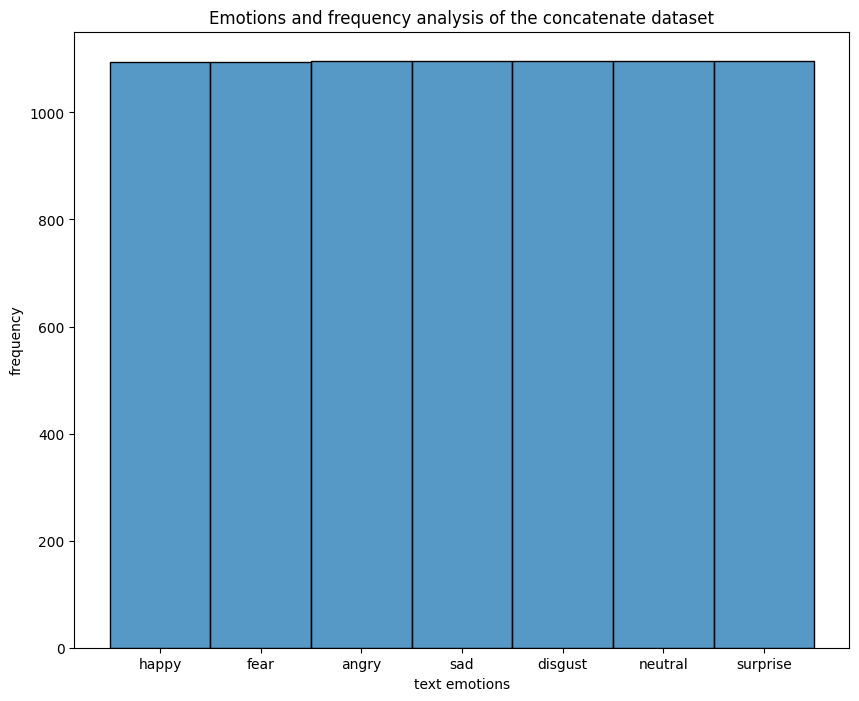

In [77]:
plt.figure(figsize=(10,8))
sns.histplot(dftodo['label'])
plt.xlabel('text emotions')
plt.ylabel('frequency')
plt.title('Emotions and frequency analysis of the concatenate dataset')
plt.show()

In [78]:
nullvalues = dftodo.isnull().sum()
print('Null values:', nullvalues)

Null values: texto    0
label    0
dtype: int64


In [18]:
dftodo['label'].value_counts()

label
angry       1096
sad         1096
disgust     1096
neutral     1096
surprise    1096
fear        1095
happy       1094
Name: count, dtype: int64

## Clean emotions text

In [16]:
import re

def clean_emotion_text(texto):
    if isinstance(texto, list): #En caso de ser lista toma el primer valor
        texto = texto[0] 

    if texto.startswith('[') and texto.endswith(']'): #Si empieza y termina con [ ] los elimina
        texto = texto[1:-1]

    texto = texto.lower()

    texto = texto.replace('á', '')
    texto = texto.replace('\n', '')
    texto = texto.replace('[]', "'")
    texto = texto.replace('', "'")

    texto = re.sub(r"@[A-Za-z0-9]+", ' ', texto)
    texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)
    texto = re.sub(r"[^a-zA-Z.'!?]", ' ', texto)
    texto = re.sub(r"#", ' ', texto)
    texto = re.sub(r"\s(?=\')", "", texto) #Eliminar los espacios que une los apóstrofes
    texto = texto.replace("' ", "'")
    texto = re.sub(r" +", ' ', texto)


    return texto

# Llamado a la función de limpieza
texto_clean = [clean_emotion_text(text) for text in tqdm(dftodo['texto'])]

100%|██████████| 7669/7669 [00:00<00:00, 56201.26it/s]


In [20]:
texto_clean

['during the period of falling in love each time that we met and especially when we had not met for a long time.',
 'when i was involved in a traffic accident.',
 'when i was driving home after several days of hard work there was a motorist ahead of me who was driving at km hour and refused despite his low speeed to let me overtake.',
 'when i lost the person who meant the most to me. ',
 "the time i knocked a deer down the sight of the animal's injuries and helplessness. the realization that the animal was so badly hurt that it had to be put down and when the animal screamed at the moment of death.",
 'when i got a letter offering me the summer job that i had applied for. ',
 'when i was going home alone one night in paris and a man came up behind me and asked me if i was not afraid to be out alone so late at night.',
 'when i was talking to him at a party for the first time in a long while and a friend came and interrupted us and he left.',
 "when my friends did not ask me to go to a

## Transformation from classes to numerics

In [17]:
labels = dftodo['label']

le = LabelEncoder()

labelEncoder = le.fit_transform(labels)

data_labels = labelEncoder

In [18]:
# get the class names
class_names = le.classes_

# get the numerics values assigned to each classes
class_values = le.transform(class_names)

# show the class names and their numerics values
for name, value in zip(class_names, class_values):
    print(f'Clase: {name}, Valor: {value}')

Clase: angry, Valor: 0
Clase: disgust, Valor: 1
Clase: fear, Valor: 2
Clase: happy, Valor: 3
Clase: neutral, Valor: 4
Clase: sad, Valor: 5
Clase: surprise, Valor: 6


## Division of the training set, testing and validation

In [19]:
x_train, x_test, y_train, y_test = train_test_split(texto_clean, data_labels, random_state=42, stratify=data_labels, test_size=0.1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=42, stratify=y_train, test_size=0.2222)

In [20]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = "1"
    os.environ['TF_CUDNN_DETERMINISM'] = "1"
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

## Data augmentation for text

In [25]:
from textattack.augmentation import EasyDataAugmenter
from tqdm import tqdm
import random
import numpy as np


# create augmenter
augmenter = EasyDataAugmenter()

# Function to apply the text augmentation
def augment_text(text, label):
    set_seed(42)
    augmented_texts = augmenter.augment(text)
    augmented_data = [(augmented_text, label) for augmented_text in augmented_texts]
    return augmented_data

# Convert zip result to list
data_with_labels = list(zip(x_train, y_train))

# Apply text aumentation to each text in texto_clean
augmented_data_list = [augment_text(text, label) for text, label in tqdm(data_with_labels, total=len(data_with_labels))]

# Flatten the list of list
augmented_data_flat = [item for sublist in augmented_data_list for item in sublist]

# Extract the generated phrases and labels
x_train_augmented = [augmented_text for augmented_text, label in augmented_data_flat]
y_train_augmented = [label for augmented_text, label in augmented_data_flat]

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
100%|██████████| 5368/5368 [14:18<00:00,  6.25it/s]  


In [26]:
#Save Augmented data
"""
import pandas as pd

df_augmented = pd.DataFrame({'Texto': x_train_augmented, 'Label': y_train_augmented})

df_augmented.to_csv('datos_aumentados_with7emotions.csv', index=False)"""

In [20]:
import pandas as pd

# Load the csv file into a dataframe
df_recuperado = pd.read_csv('datos_aumentados_with7emotions.csv')

# Get the augmented data and labels
x_train_augmented = df_recuperado['Texto'].tolist()
y_train_augmented = df_recuperado['Label'].tolist()

## Glove and Word2Vec Embeddings

In [86]:
# Defining pre-processing parameters
max_len = 300
vocab_size = 300

In [87]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train_augmented)

In [88]:
# Get the word_index
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

9944

In [89]:
X_train_seq = tokenizer.texts_to_sequences(x_train_augmented)
X_val_seq = tokenizer.texts_to_sequences(x_val)
X_test_seq = tokenizer.texts_to_sequences(x_test)

In [90]:
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

### Glove

In [91]:

unique, counts = np.unique(y_train_augmented, return_counts=True)
print(dict(zip(unique, counts)))


word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  

# Load the Glove model file
glove_file = 'glove.6B.300d.txt'
embedding_index = {}
with open(glove_file, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

{0: 3068, 1: 3068, 2: 3068, 3: 3064, 4: 2867, 5: 3067, 6: 2697}


In [92]:
y_train_augmented = np.array(y_train_augmented)


In [93]:
print(f'y_train_augmented shape: {y_train_augmented.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'y_test shape: {y_test.shape}')


y_train_augmented shape: (20899,)
y_val shape: (1534,)
y_test shape: (767,)


In [94]:
y_train_one_hot = to_categorical(y_train_augmented, num_classes=7)
y_val_one_hot = to_categorical(y_val, num_classes=7)
y_test_one_hot = to_categorical(y_test, num_classes=7)

In [95]:
input_layer = tf.keras.layers.Input(shape=(max_len,))

embd = Embedding(input_dim=vocab_size, output_dim=300, input_length=max_len, weights=[embedding_matrix], trainable=False)(input_layer)
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(embd)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(embd)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(embd)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout)
modelGlove2 = tf.keras.models.Model(inputs=input_layer, outputs=dense_output)

modelGlove2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
modelGlove2.summary()


print(modelGlove2.summary())


historyGlove2 = modelGlove2.fit(X_train_padded, y_train_one_hot, epochs=20, batch_size=128, validation_data=(X_val_padded,y_val_one_hot), shuffle=True)

print(modelGlove2.evaluate(X_test_padded,y_test_one_hot))

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 300, 300)     2983500     ['input_17[0][0]']               
                                                                                                  
 conv1d_24 (Conv1D)             (None, 300, 128)     76928       ['embedding[0][0]']              
                                                                                                  
 conv1d_25 (Conv1D)             (None, 300, 128)     115328      ['embedding[0][0]']              
                                                                                            

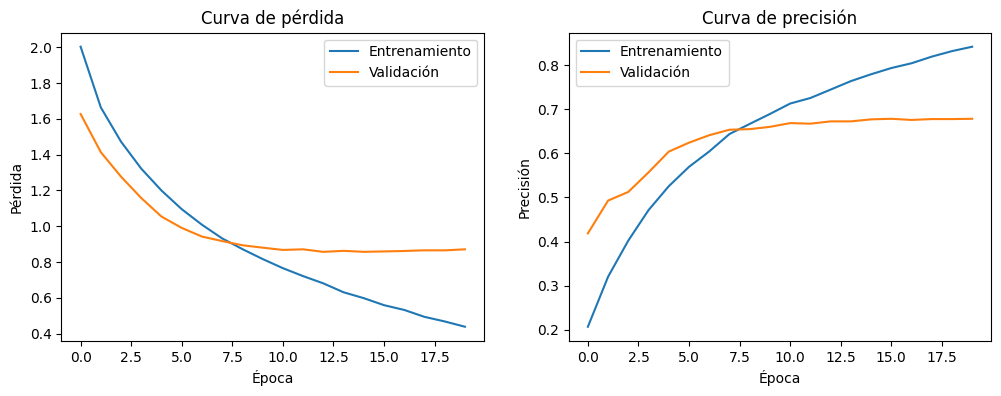

In [96]:
import matplotlib.pyplot as plt


train_loss = historyGlove2.history['loss']
val_loss = historyGlove2.history['val_loss']
train_accuracy = historyGlove2.history['accuracy']
val_accuracy = historyGlove2.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Word2Vec

In [ ]:
y_train_one_hot = to_categorical(y_train_augmented, num_classes=7)
y_val_one_hot = to_categorical(y_val, num_classes=7)
y_test_one_hot = to_categorical(y_test, num_classes=7)

In [98]:
from gensim.models import KeyedVectors

unique, counts = np.unique(y_train_augmented, return_counts=True)
print(dict(zip(unique, counts)))


word_index = tokenizer.word_index
vocab_size = len(word_index) + 1 


# Load Word2vec model file
word2vec = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# Create embedding matrix
embedding_matrix_word2vec = np.zeros((vocab_size, 300))
for word, i in word_index.items():
    if word in word2vec:
        embedding_matrix_word2vec[i] = word2vec[word]

{0: 3068, 1: 3068, 2: 3068, 3: 3064, 4: 2867, 5: 3067, 6: 2697}


In [99]:
input_layer = tf.keras.layers.Input(shape=(max_len,))

embd = Embedding(input_dim=vocab_size, output_dim=300, input_length=max_len, weights=[embedding_matrix_word2vec], trainable=False)(input_layer)
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(embd)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(embd)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(embd)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout)
modelWord2vec2 = tf.keras.models.Model(inputs=input_layer, outputs=dense_output)

modelWord2vec2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
modelWord2vec2.summary()


print(modelWord2vec2.summary())


historyWord2vec2 = modelWord2vec2.fit(X_train_padded, y_train_one_hot, epochs=20, batch_size=128, validation_data=(X_val_padded,y_val_one_hot), shuffle=True)

print(modelWord2vec2.evaluate(X_test_padded,y_test_one_hot))

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 300, 300)     2983500     ['input_18[0][0]']               
                                                                                                  
 conv1d_27 (Conv1D)             (None, 300, 128)     76928       ['embedding_1[0][0]']            
                                                                                                  
 conv1d_28 (Conv1D)             (None, 300, 128)     115328      ['embedding_1[0][0]']            
                                                                                            

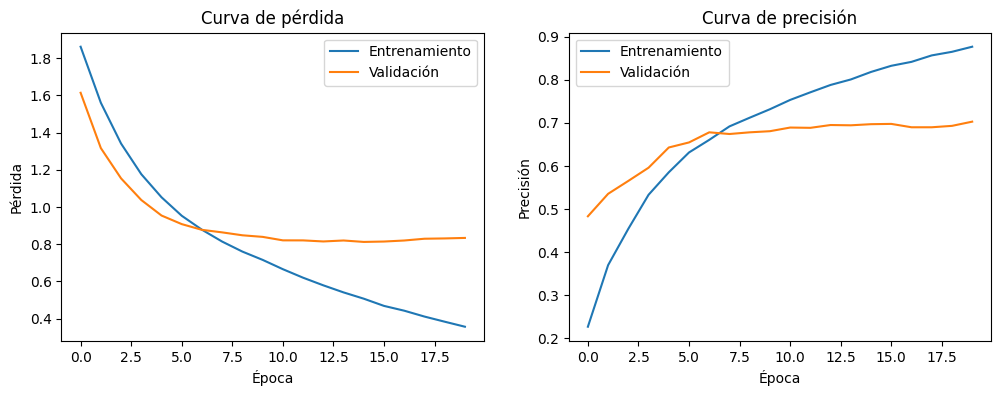

In [100]:
import matplotlib.pyplot as plt


train_loss = historyWord2vec2.history['loss']
val_loss = historyWord2vec2.history['val_loss']
train_accuracy = historyWord2vec2.history['accuracy']
val_accuracy = historyWord2vec2.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

## Definition Bert and Roberta

In [21]:
from transformers import BertTokenizer, TFBertModel,RobertaTokenizer,TFRobertaModel

tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

tokenizer_roberta = RobertaTokenizer.from_pretrained("FacebookAI/roberta-base")
roberta_model = TFRobertaModel.from_pretrained("FacebookAI/roberta-base")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

## Tokenizer words

### Bert

In [36]:
def tokenizer_bert_fn(texts, labels):
    input_ids = []
    attention_masks = []
    label_array = tf.one_hot(labels, depth=7)

    for text in texts:
        inputs = tokenizer_bert(text, 
                                padding="max_length", 
                                truncation=True,
                                max_length=300,
                                return_tensors='tf')
        input_ids.append(inputs['input_ids'])
        attention_masks.append(inputs['attention_mask'])

    return np.array(input_ids), np.array(attention_masks), label_array

input_ids_train, attention_mask_train, labels_train = tokenizer_bert_fn(x_train_augmented, y_train_augmented)
input_ids_test, attention_mask_test, labels_test = tokenizer_bert_fn(x_test, y_test)
input_ids_val, attention_mask_val, labels_val = tokenizer_bert_fn(x_val, y_val)

input_ids_train = np.squeeze(input_ids_train, axis=1)
attention_mask_train = np.squeeze(attention_mask_train, axis=1)

input_ids_test = np.squeeze(input_ids_test, axis=1)
attention_mask_test = np.squeeze(attention_mask_test, axis=1)

input_ids_val = np.squeeze(input_ids_val, axis=1)
attention_mask_val = np.squeeze(attention_mask_val, axis=1)

### Roberta

In [22]:
def tokenizer_roberta_fn(texts, labels):
    input_ids = []
    attention_masks = []
    label_array = tf.one_hot(labels, depth=7)

    for text in texts:
        inputs = tokenizer_roberta(text, 
                                padding="max_length", 
                                truncation=True,
                                max_length=300,
                                return_tensors='tf')
        input_ids.append(inputs['input_ids'])
        attention_masks.append(inputs['attention_mask'])

    return np.array(input_ids), np.array(attention_masks), label_array

input_ids_train_roberta, attention_mask_train_roberta, labels_train_roberta = tokenizer_roberta_fn(x_train_augmented, y_train_augmented)
input_ids_test_roberta, attention_mask_test_roberta, labels_test_roberta = tokenizer_roberta_fn(x_test, y_test)
input_ids_val_roberta, attention_mask_val_roberta, labels_val_roberta = tokenizer_roberta_fn(x_val, y_val)

input_ids_train_roberta = np.squeeze(input_ids_train_roberta, axis=1)
attention_mask_train_roberta = np.squeeze(attention_mask_train_roberta, axis=1)

input_ids_test_roberta = np.squeeze(input_ids_test_roberta, axis=1)
attention_mask_test_roberta = np.squeeze(attention_mask_test_roberta, axis=1)

input_ids_val_roberta = np.squeeze(input_ids_val_roberta, axis=1)
attention_mask_val_roberta = np.squeeze(attention_mask_val_roberta, axis=1)

## Model 1 Roberta + NGram CNN - 7 Emotions (mejor 81% testeo)

In [38]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
roberta_output = roberta_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(roberta_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(roberta_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(roberta_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout)
modelTestRoberta7Emotions = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

modelTestRoberta7Emotions.layers[2].trainable=False

modelTestRoberta7Emotions.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
modelTestRoberta7Emotions.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_5[0][0]',                
 el)                            thPoolingAndCrossAt               'input_6[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [39]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/128batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/128batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/128batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/128batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

#--------------------------------------------------------------------------------
historyRoberta7Emotions = modelTestRoberta7Emotions.fit(
    [input_ids_train_roberta, attention_mask_train_roberta], labels_train_roberta,
    validation_data=([input_ids_val_roberta, attention_mask_val_roberta], labels_val_roberta),
    epochs=20,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=128, shuffle=True
)


#print(model23.evaluate([input_ids_test, attention_mask_test], labels_test))

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/20
164/164 [==============================] - ETA: 0s - loss: 2.1656 - accuracy: 0.2293 - recall_2: 0.0721
Epoch 1: val_accuracy improved from -inf to 0.47914, saving model to model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/128batch\BERT_CNN_model_best_01_val_0.4791.h5
164/164 [==============================] - 415s 2s/step - loss: 2.1656 - accuracy: 0.2293 - recall_2: 0.0721 - val_loss: 1.5634 - val_accuracy: 0.4791 - val_recall_2: 6.5189e-04
Epoch 2/20
164/164 [==============================] - ETA: 0s - loss: 1.5330 - accuracy: 0.3517 - recall_2: 0.1166
Epoch 2: val_accuracy improved from 0.47914 to 0.58866, saving model to model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/128batch\BERT_CNN_model_best_02_val_0.5887.h5
164/164 [==============================] - 433s 3s/step - loss: 1.5330 - accuracy: 0.3517 - recall_2: 0.1166 - val_loss: 1.3591 - val_accuracy: 0

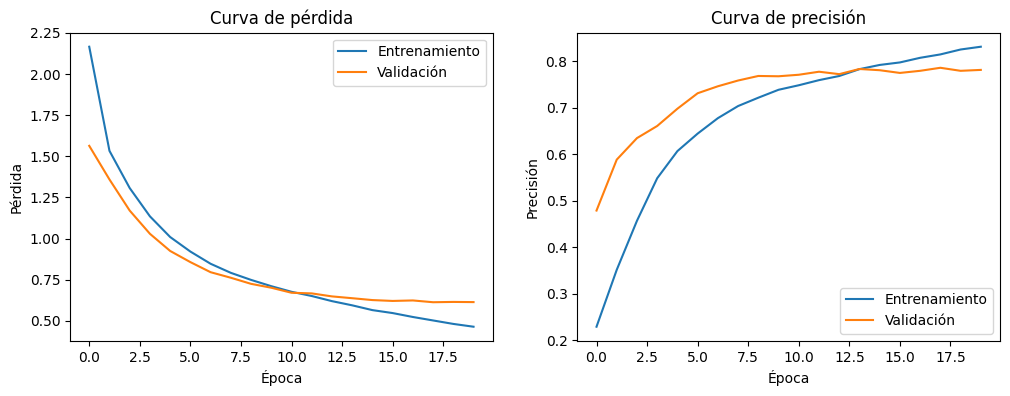

In [40]:
import matplotlib.pyplot as plt


train_loss = historyRoberta7Emotions.history['loss']
val_loss = historyRoberta7Emotions.history['val_loss']
train_accuracy = historyRoberta7Emotions.history['accuracy']
val_accuracy = historyRoberta7Emotions.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Evaluate on test set

In [47]:
def custom_objects_fn_roberta():
    return {'TFRobertaModel': TFRobertaModel}

model_load3 = load_model(r'model\BERTHugginfFace\OptimizationBestModel\7Emotions\Roberta\128batch\BERT_CNN_model_best_14_val_0.7836.h5', custom_objects=custom_objects_fn_roberta())
print(model_load3.summary())
evaluate = model_load3.evaluate([input_ids_test_roberta, attention_mask_test_roberta], labels_test_roberta)
print(evaluate)

Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_roberta_model_1 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_5[0][0]',                
 odel)                          thPoolingAndCrossAt               'input_6[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [59]:
evaluate_1 = model_load3.evaluate([input_ids_train_roberta, attention_mask_train_roberta], labels_train_roberta)
print("Evaluación train: ",evaluate_1)

654/654 [==============================] - 269s 411ms/step - loss: 0.4903 - accuracy: 0.8550 - recall_2: 0.7399
Evaluación train:  [0.4902797341346741, 0.8549691438674927, 0.7399396896362305]


In [48]:
y_true = np.argmax(labels_test_roberta, axis=-1)
y_pred = model_load3.predict([input_ids_test_roberta, attention_mask_test_roberta])
y_pred = np.argmax(y_pred, axis=-1)

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(matrix)


24/24 [==============================] - 13s 406ms/step
              precision    recall  f1-score   support

           0       0.63      0.77      0.69       110
           1       0.81      0.68      0.74       109
           2       0.87      0.80      0.83       109
           3       0.86      0.94      0.90       109
           4       0.88      0.76      0.82       110
           5       0.77      0.75      0.76       110
           6       0.82      0.90      0.86       110

    accuracy                           0.80       767
   macro avg       0.81      0.80      0.80       767
weighted avg       0.81      0.80      0.80       767

[[ 85  13   3   1   0   8   0]
 [ 23  74   2   2   2   6   0]
 [  9   1  87   6   0   6   0]
 [  1   1   2 102   0   3   0]
 [  1   0   2   0  84   1  22]
 [ 15   2   4   7   0  82   0]
 [  1   0   0   0  10   0  99]]


Text(95.72222222222221, 0.5, 'True')

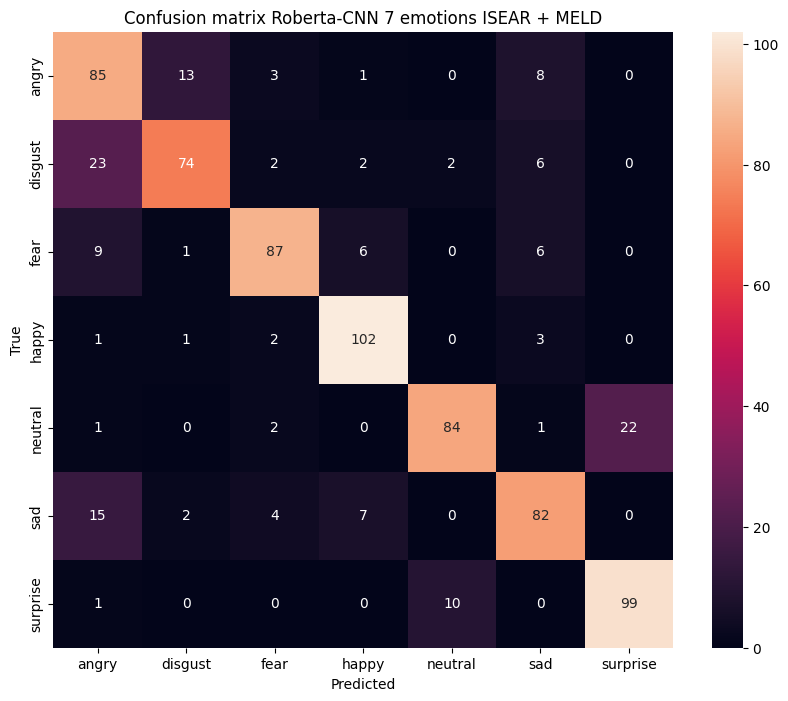

In [55]:
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

plt.figure(figsize=(10,8))
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.title('Confusion matrix Roberta-CNN 7 emotions ISEAR + MELD')
plt.xlabel('Predicted')
plt.ylabel('True')

In [27]:
predictions_perplexity = model_load3.predict([input_ids_test_roberta, attention_mask_test_roberta])

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction='none')
loss_perplexity = loss_fn(labels_test_roberta, predictions_perplexity)

#Perplexity formula
perplexity = tf.exp(tf.reduce_mean(loss_perplexity))

print("Perplexity: ", perplexity.numpy())


24/24 [==============================] - 141s 3s/step
Perplexity:  4.350032


## Model 2 Bert + NGram CNN - 7 Emotions

In [41]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout)
model247Emotions = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model247Emotions.layers[2].trainable=False

model247Emotions.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
model247Emotions.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_7[0][0]',                
                                thPoolingAndCrossAt               'input_8[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [42]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/7Emotions/BERT/128batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/7Emotions/BERT/128batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/7Emotions/BERT/128batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/7Emotions/BERT/128batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

#--------------------------------------------------------------------------------
history247Emotions = model247Emotions.fit(
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=15,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=128, shuffle=True
)


#print(model23.evaluate([input_ids_test, attention_mask_test], labels_test))

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/15
164/164 [==============================] - ETA: 0s - loss: 1.8690 - accuracy: 0.3066 - recall_3: 0.1247
Epoch 1: val_accuracy improved from -inf to 0.63364, saving model to model/BERTHugginfFace/7Emotions/BERT/128batch\BERT_CNN_model_best_01_val_0.6336.h5
164/164 [==============================] - 346s 2s/step - loss: 1.8690 - accuracy: 0.3066 - recall_3: 0.1247 - val_loss: 1.1315 - val_accuracy: 0.6336 - val_recall_3: 0.2053
Epoch 2/15
164/164 [==============================] - ETA: 0s - loss: 1.2374 - accuracy: 0.5064 - recall_3: 0.2969
Epoch 2: val_accuracy improved from 0.63364 to 0.67731, saving model to model/BERTHugginfFace/7Emotions/BERT/128batch\BERT_CNN_model_best_02_val_0.6773.h5
164/164 [==============================] - 330s 2s/step - loss: 1.2374 - accuracy: 0.5064 - recall_3: 0.2969 - val_loss: 0.8723 - val_accuracy: 0.6773 - val_recall_3: 0.4622
Epoch 3/15
164/164 [=====

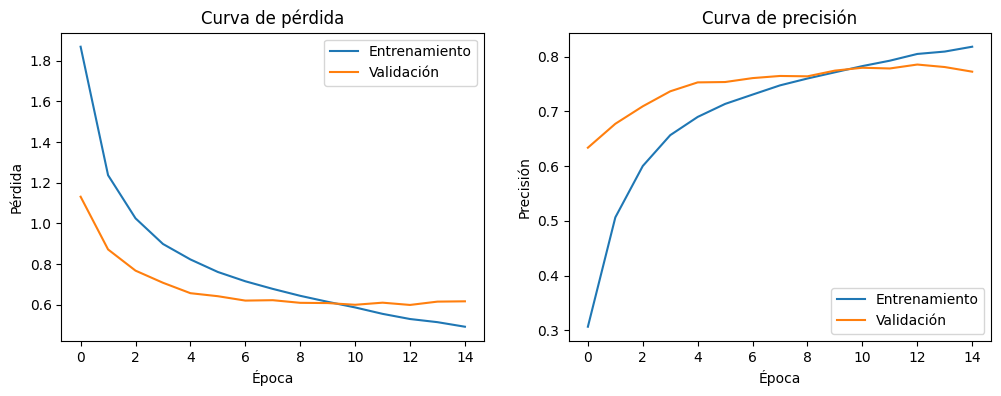

In [43]:
import matplotlib.pyplot as plt


train_loss = history247Emotions.history['loss']
val_loss = history247Emotions.history['val_loss']
train_accuracy = history247Emotions.history['accuracy']
val_accuracy = history247Emotions.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Evaluate on test set

In [50]:
def custom_objects_fn():
    return {'TFBertModel': TFBertModel}

model_load4 = load_model(r'C:\Users\bryan\OneDrive\Escritorio\Tesis\Codigo tesis\Texto\code 6\model\BERTHugginfFace\7Emotions\BERT\128batch\BERT_CNN_model_best_13_val_0.7855.h5', custom_objects=custom_objects_fn())
print(model_load4.summary())
evaluate2 = model_load4.evaluate([input_ids_test, attention_mask_test], labels_test)
print("Evaluación test: "evaluate2)

Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_7[0][0]',                
                                thPoolingAndCrossAt               'input_8[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [58]:
evaluate2_1 = model_load4.evaluate([input_ids_train, attention_mask_train], labels_train)
print("Evaluación train: ",evaluate2_1)

  3/654 [..............................] - ETA: 4:33 - loss: 0.2604 - accuracy: 0.8854 - recall_3: 0.8438

654/654 [==============================] - 313s 478ms/step - loss: 0.3458 - accuracy: 0.8807 - recall_3: 0.8385
Evaluación train:  [0.3457919955253601, 0.8807119727134705, 0.83846116065979]


In [51]:
y_true2 = np.argmax(labels_test, axis=-1)
y_pred2 = model_load4.predict([input_ids_test, attention_mask_test])
y_pred2 = np.argmax(y_pred2, axis=-1)

report2 = classification_report(y_true2, y_pred2)
print(report2)

matrix2 = confusion_matrix(y_true2, y_pred2)
print(matrix2)

24/24 [==============================] - 13s 409ms/step
              precision    recall  f1-score   support

           0       0.67      0.73      0.70       110
           1       0.78      0.67      0.72       109
           2       0.89      0.85      0.87       109
           3       0.86      0.89      0.87       109
           4       0.83      0.85      0.84       110
           5       0.74      0.74      0.74       110
           6       0.84      0.89      0.87       110

    accuracy                           0.80       767
   macro avg       0.80      0.80      0.80       767
weighted avg       0.80      0.80      0.80       767

[[80 14  2  4  1  9  0]
 [19 73  5  3  4  5  0]
 [ 3  1 93  3  0  8  1]
 [ 2  1  2 97  1  6  0]
 [ 0  0  0  0 93  0 17]
 [15  4  3  6  1 81  0]
 [ 0  0  0  0 12  0 98]]


Text(95.72222222222221, 0.5, 'True')

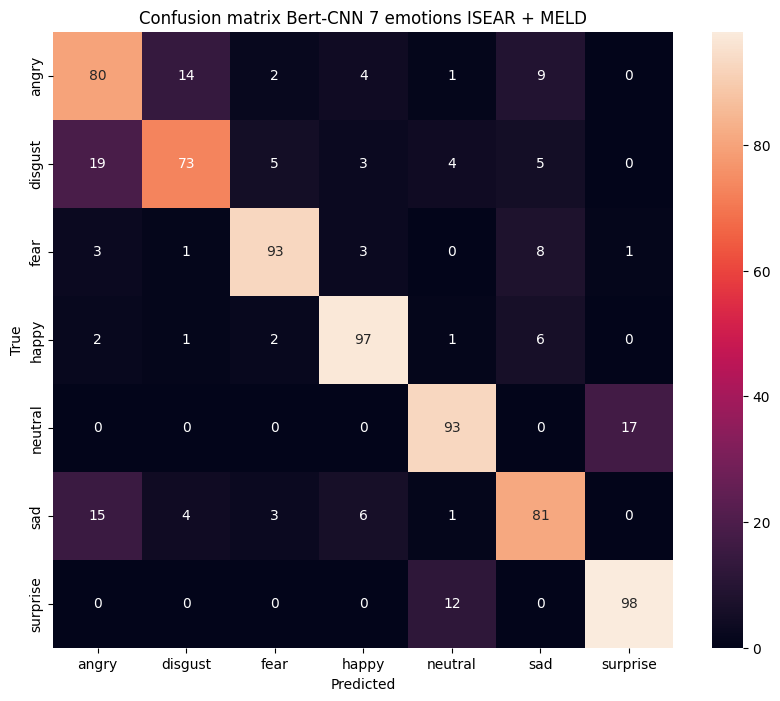

In [56]:
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

plt.figure(figsize=(10,8))
sns.heatmap(matrix2, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.title('Confusion matrix Bert-CNN 7 emotions ISEAR + MELD')
plt.xlabel('Predicted')
plt.ylabel('True')

## Model 3 Roberta + NGram CNN + Dropout - 7 Emotions

In [28]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
roberta_output = roberta_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(roberta_output)
x_1 = tf.keras.layers.Dropout(0.2)(x_1)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(roberta_output)
x_2 = tf.keras.layers.Dropout(0.2)(x_2)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(roberta_output)
x_3 = tf.keras.layers.Dropout(0.2)(x_3)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout)
modelTestRoberta7Emotions2 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

modelTestRoberta7Emotions2.layers[2].trainable=False

modelTestRoberta7Emotions2.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
modelTestRoberta7Emotions2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                           

In [29]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta_Dropout/128batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta_Dropout/128batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta_Dropout/128batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta_Dropout/128batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

#--------------------------------------------------------------------------------
historyRoberta7Emotions2 = modelTestRoberta7Emotions2.fit(
    [input_ids_train_roberta, attention_mask_train_roberta], labels_train_roberta,
    validation_data=([input_ids_val_roberta, attention_mask_val_roberta], labels_val_roberta),
    epochs=20,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=64, shuffle=True
)


#print(model23.evaluate([input_ids_test, attention_mask_test], labels_test))

Epoch 1/20
327/327 [==============================] - ETA: 0s - loss: 2.0565 - accuracy: 0.2560 - recall: 0.0879
Epoch 1: val_accuracy improved from -inf to 0.53911, saving model to model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta_Dropout/128batch\BERT_CNN_model_best_01_val_0.5391.h5
327/327 [==============================] - 406s 1s/step - loss: 2.0565 - accuracy: 0.2560 - recall: 0.0879 - val_loss: 1.5599 - val_accuracy: 0.5391 - val_recall: 6.5189e-04
Epoch 2/20
327/327 [==============================] - ETA: 0s - loss: 1.3864 - accuracy: 0.4244 - recall: 0.1876
Epoch 2: val_accuracy improved from 0.53911 to 0.63494, saving model to model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta_Dropout/128batch\BERT_CNN_model_best_02_val_0.6349.h5
327/327 [==============================] - 340s 1s/step - loss: 1.3864 - accuracy: 0.4244 - recall: 0.1876 - val_loss: 1.2672 - val_accuracy: 0.6349 - val_recall: 0.0847
Epoch 3/20
327/327 [==============================] - ETA

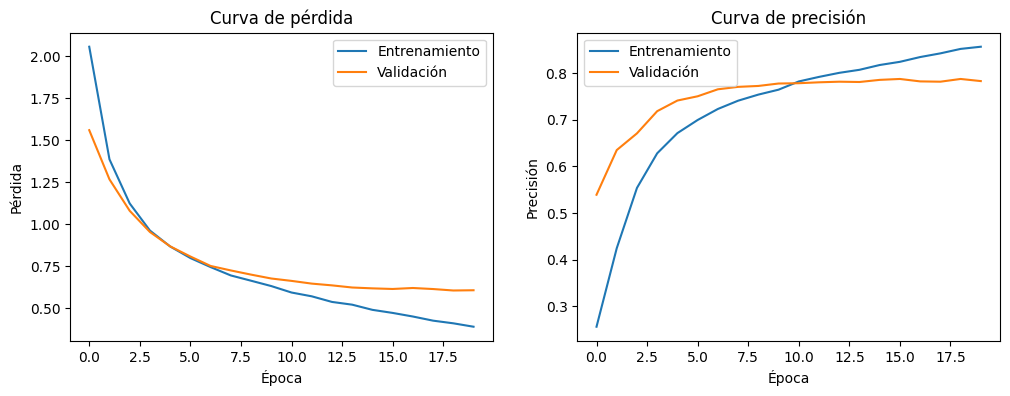

In [30]:
import matplotlib.pyplot as plt


train_loss = historyRoberta7Emotions2.history['loss']
val_loss = historyRoberta7Emotions2.history['val_loss']
train_accuracy = historyRoberta7Emotions2.history['accuracy']
val_accuracy = historyRoberta7Emotions2.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

## Model 4 Roberta + NGram CNN - 7 Emotions - Double cleaning Mejor (81%)

In [24]:
import pandas as pd

# Load the csv file into a dataframe
df_recuperado = pd.read_csv('datos_aumentados_with7emotions.csv')

# Get the augmented data and labels
x_train_augmented = df_recuperado['Texto'].tolist()
y_train_augmented = df_recuperado['Label'].tolist()

In [26]:
import re
import spacy
from nltk.corpus import words
nltk.download('words')



nlp = spacy.load("en_core_web_sm") #Spacy model english text
valid_words = set(words.words())  

def correct_ii_errors(text):
    words = text.split()
    corrected_words = []
    for word in words:
        if 'ii' in word.lower() and word.lower() not in valid_words:
            corrected_word = word.replace('ii', 'i')
            if corrected_word.lower() in valid_words:
                corrected_words.append(corrected_word)
            else:
                corrected_words.append(word)
        else:
            corrected_words.append(word)
    return ' '.join(corrected_words)

def clean_emotion_text(texto):
    if isinstance(texto, list): 
        texto = texto[0] 

    if texto.startswith('[') and texto.endswith(']'): 
        texto = texto[1:-1]

    texto = texto.lower()

    texto = texto.replace('á', '')
    texto = texto.replace('\n', '')
    texto = texto.replace('[]', "'")
    texto = texto.replace('', "'")

    texto = re.sub(r"@[A-Za-z0-9]+", ' ', texto)
    texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)
    texto = re.sub(r"[^a-zA-Z.'!?]", ' ', texto)
    texto = re.sub(r"(?<!\S)\?(?!\S)", '', texto)
    texto = re.sub(r"(?<!\S)\.(?!\S)", '', texto)
    texto = re.sub(r"#", ' ', texto)
    texto = re.sub(r"\s(?=\')", "", texto) 
    texto = texto.replace("' ", "'")
    texto = re.sub(r" +", ' ', texto)

    corrected_text = correct_ii_errors(texto)  

    return corrected_text


x_train_augmentedwith = [clean_emotion_text(text) for text in tqdm(x_train_augmented)]

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
100%|██████████| 20899/20899 [00:00<00:00, 31911.47it/s]


In [27]:
def tokenizer_roberta_fn(texts, labels):
    input_ids = []
    attention_masks = []
    label_array = tf.one_hot(labels, depth=7)

    for text in texts:
        inputs = tokenizer_roberta(text, 
                                padding="max_length", 
                                truncation=True,
                                max_length=300,
                                return_tensors='tf')
        input_ids.append(inputs['input_ids'])
        attention_masks.append(inputs['attention_mask'])

    return np.array(input_ids), np.array(attention_masks), label_array

input_ids_train_roberta, attention_mask_train_roberta, labels_train_roberta = tokenizer_roberta_fn(x_train_augmentedwith, y_train_augmented)
input_ids_test_roberta, attention_mask_test_roberta, labels_test_roberta = tokenizer_roberta_fn(x_test, y_test)
input_ids_val_roberta, attention_mask_val_roberta, labels_val_roberta = tokenizer_roberta_fn(x_val, y_val)

input_ids_train_roberta = np.squeeze(input_ids_train_roberta, axis=1)
attention_mask_train_roberta = np.squeeze(attention_mask_train_roberta, axis=1)

input_ids_test_roberta = np.squeeze(input_ids_test_roberta, axis=1)
attention_mask_test_roberta = np.squeeze(attention_mask_test_roberta, axis=1)

input_ids_val_roberta = np.squeeze(input_ids_val_roberta, axis=1)
attention_mask_val_roberta = np.squeeze(attention_mask_val_roberta, axis=1)

In [28]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
roberta_output = roberta_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(roberta_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(roberta_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(roberta_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout)
modelTestRoberta7Emotions2 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

modelTestRoberta7Emotions2.layers[2].trainable=False

modelTestRoberta7Emotions2.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
modelTestRoberta7Emotions2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                           

In [29]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta_clean2/128batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta_clean2/128batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta_clean2/128batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta_clean2/128batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

#--------------------------------------------------------------------------------
historyRoberta7Emotions2 = modelTestRoberta7Emotions2.fit(
    [input_ids_train_roberta, attention_mask_train_roberta], labels_train_roberta,
    validation_data=([input_ids_val_roberta, attention_mask_val_roberta], labels_val_roberta),
    epochs=20,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=128, shuffle=True
)


#print(model23.evaluate([input_ids_test, attention_mask_test], labels_test))

Epoch 1/20
164/164 [==============================] - ETA: 0s - loss: 2.1907 - accuracy: 0.2199 - recall: 0.0656
Epoch 1: val_accuracy improved from -inf to 0.44003, saving model to model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta_clean2/128batch\BERT_CNN_model_best_01_val_0.4400.h5
164/164 [==============================] - 384s 2s/step - loss: 2.1907 - accuracy: 0.2199 - recall: 0.0656 - val_loss: 1.5795 - val_accuracy: 0.4400 - val_recall: 0.0000e+00
Epoch 2/20
164/164 [==============================] - ETA: 0s - loss: 1.5323 - accuracy: 0.3552 - recall: 0.1172
Epoch 2: val_accuracy improved from 0.44003 to 0.56910, saving model to model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta_clean2/128batch\BERT_CNN_model_best_02_val_0.5691.h5
164/164 [==============================] - 332s 2s/step - loss: 1.5323 - accuracy: 0.3552 - recall: 0.1172 - val_loss: 1.3539 - val_accuracy: 0.5691 - val_recall: 0.0274
Epoch 3/20
164/164 [==============================] - ETA: 

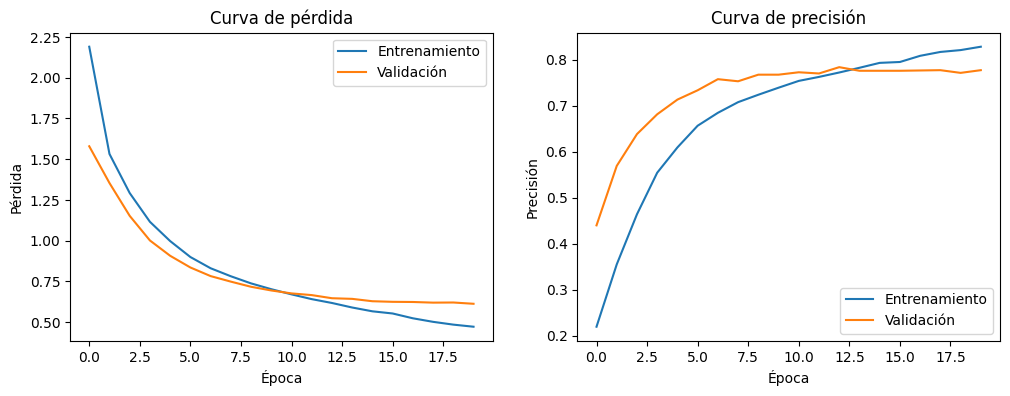

In [38]:
import matplotlib.pyplot as plt


train_loss = historyRoberta7Emotions2.history['loss']
val_loss = historyRoberta7Emotions2.history['val_loss']
train_accuracy = historyRoberta7Emotions2.history['accuracy']
val_accuracy = historyRoberta7Emotions2.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [34]:
def custom_objects_fn_roberta():
    return {'TFRobertaModel': TFRobertaModel}

model_load5 = load_model(r'model\BERTHugginfFace\OptimizationBestModel\7Emotions\Roberta_clean2\128batch\BERT_CNN_model_best_13_val_0.7836.h5', custom_objects_fn_roberta())
print(model_load5.summary())
evaluate3 = model_load5.evaluate([input_ids_test_roberta, attention_mask_test_roberta], labels_test_roberta)
print("Evaluación test: ",evaluate3)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_roberta_model_2 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_1[0][0]',                
 odel)                          thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                           

In [39]:
evaluate4 = model_load5.evaluate([input_ids_train_roberta, attention_mask_train_roberta], labels_train_roberta)
print("Evaluación train: ",evaluate4)

654/654 [==============================] - 278s 424ms/step - loss: 0.5233 - accuracy: 0.8500 - recall: 0.7112
Evaluación train:  [0.5233400464057922, 0.8500406742095947, 0.7112302184104919]


In [35]:
y_true3 = np.argmax(labels_test_roberta, axis=-1)
y_pred3 = model_load5.predict([input_ids_test_roberta, attention_mask_test_roberta])
y_pred3 = np.argmax(y_pred3, axis=-1)

report3 = classification_report(y_true3, y_pred3)
print(report3)

matrix3 = confusion_matrix(y_true3, y_pred3)
print(matrix3)

24/24 [==============================] - 13s 410ms/step
              precision    recall  f1-score   support

           0       0.72      0.79      0.75       110
           1       0.79      0.69      0.74       109
           2       0.83      0.83      0.83       109
           3       0.84      0.92      0.88       109
           4       0.87      0.76      0.81       110
           5       0.79      0.76      0.78       110
           6       0.82      0.90      0.86       110

    accuracy                           0.81       767
   macro avg       0.81      0.81      0.81       767
weighted avg       0.81      0.81      0.81       767

[[ 87  15   1   1   0   6   0]
 [ 18  75   6   3   2   5   0]
 [  3   1  90   7   0   8   0]
 [  2   1   3 100   0   3   0]
 [  0   0   2   2  84   0  22]
 [ 11   3   6   6   0  84   0]
 [  0   0   0   0  11   0  99]]


Text(95.72222222222221, 0.5, 'True')

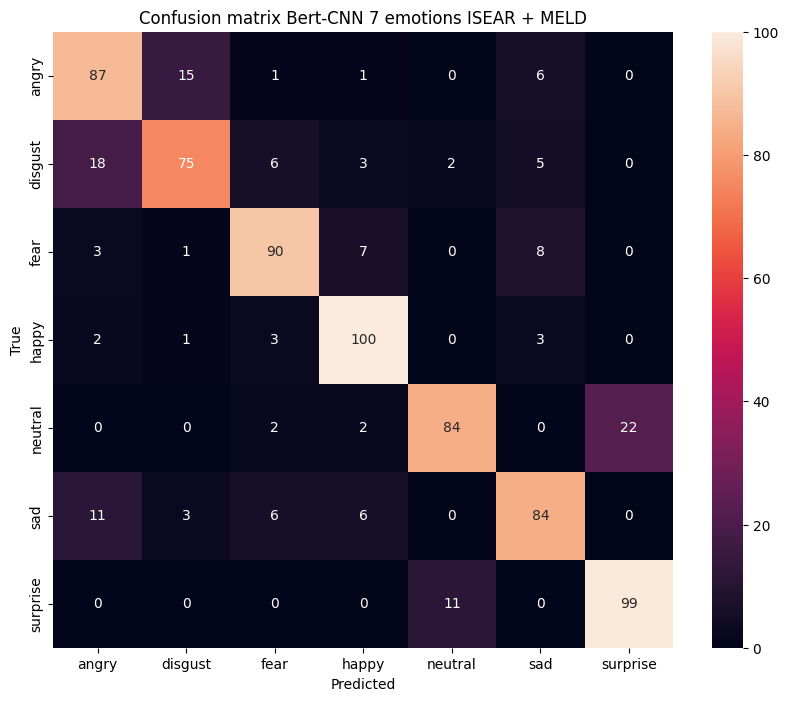

In [36]:
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

plt.figure(figsize=(10,8))
sns.heatmap(matrix3, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.title('Confusion matrix Bert-CNN 7 emotions ISEAR + MELD')
plt.xlabel('Predicted')
plt.ylabel('True')

Text(95.72222222222221, 0.5, 'True')

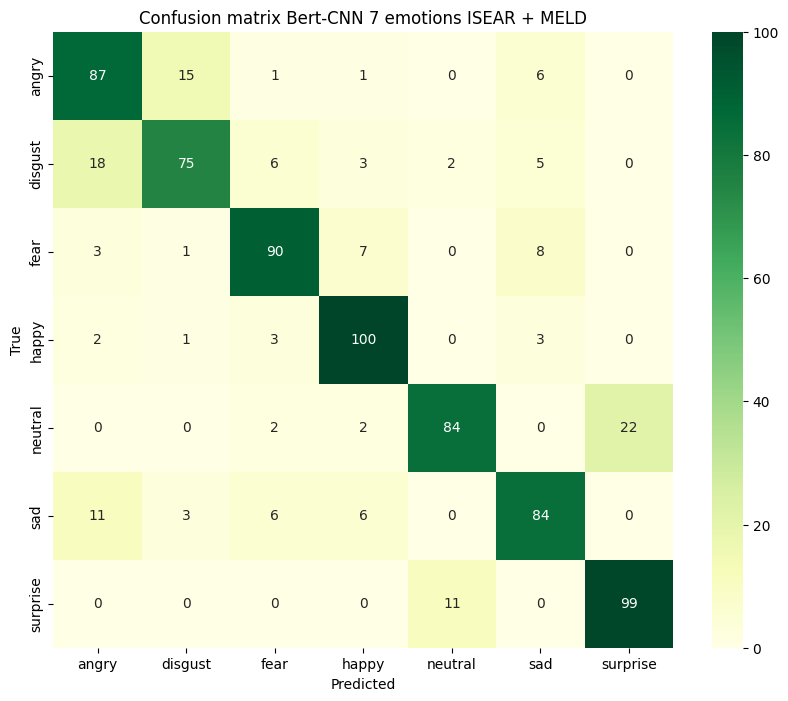

In [28]:
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

plt.figure(figsize=(10,8))
sns.heatmap(matrix3, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='YlGn')
plt.title('Confusion matrix Bert-CNN 7 emotions ISEAR + MELD')
plt.xlabel('Predicted')
plt.ylabel('True')

In [37]:
predictions_perplexity2 = model_load5.predict([input_ids_test_roberta, attention_mask_test_roberta])

loss_fn2 = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction='none')
loss_perplexity2 = loss_fn2(labels_test_roberta, predictions_perplexity2)

#Perplexity formula
perplexity2 = tf.exp(tf.reduce_mean(loss_perplexity2))

print("Perplexity: ", perplexity2.numpy())

24/24 [==============================] - 10s 414ms/step
Perplexity:  4.402052


## With 7 emotions with Lemmacitation

In [31]:
import re
import spacy

nlp = spacy.load("en_core_web_sm") #Spacy model english text

def clean_emotion_text(texto):
    if isinstance(texto, list): #En caso de ser lista toma el primer valor
        texto = texto[0] 

    if texto.startswith('[') and texto.endswith(']'): #Si empieza y termina con [ ] los elimina
        texto = texto[1:-1]

    texto = texto.lower()

    texto = texto.replace('á', '')
    texto = texto.replace('\n', '')
    texto = texto.replace('[]', "'")
    texto = texto.replace('', "'")

    texto = re.sub(r"@[A-Za-z0-9]+", ' ', texto)
    texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)
    texto = re.sub(r"[^a-zA-Z.'!?]", ' ', texto)
    texto = re.sub(r"#", ' ', texto)
    texto = re.sub(r"\s(?=\')", "", texto) #Eliminar los espacios que une los apóstrofes
    texto = texto.replace("' ", "'")
    texto = re.sub(r" +", ' ', texto)

    doc = nlp(texto) #Convert text in tokens
    lemmas = [token.lemma_ if token.pos_ != 'PROPN' else token.text for token in doc]  # Lematización, excepto para los nombres propios
    #Join the tokens
    lematized_text = ' '.join(lemmas)

    lematized_text = re.sub(r"\s(?=\')", "", lematized_text) #Eliminar los espacios que une los apóstrofes
    lematized_text = re.sub(r"\s(?=\.)", "", lematized_text) #Eliminar los espacios que une los .
    lematized_text = re.sub(r"\s(?=\!)", "", lematized_text) #Eliminar los espacios que une los !
    lematized_text = re.sub(r"\s(?=\?)", "", lematized_text) #Eliminar los espacios que une los ?
    lematized_text = re.sub(r"\b\s+(n't\b)", r"\1", lematized_text)

    return lematized_text

# Llamado a la función de limpieza
texto_clean_with_lemmazited = [clean_emotion_text(text) for text in tqdm(dftodo['texto'])]

100%|██████████| 7669/7669 [00:54<00:00, 141.36it/s]


In [32]:
labels = dftodo['label']

le = LabelEncoder()

labelEncoder = le.fit_transform(labels)

data_labels = labelEncoder

In [33]:
# get the class names
class_names = le.classes_

# get the numerics values assigned to each classes
class_values = le.transform(class_names)

# show the class names and their numerics values
for name, value in zip(class_names, class_values):
    print(f'Clase: {name}, Valor: {value}')

Clase: angry, Valor: 0
Clase: disgust, Valor: 1
Clase: fear, Valor: 2
Clase: happy, Valor: 3
Clase: neutral, Valor: 4
Clase: sad, Valor: 5
Clase: surprise, Valor: 6


In [34]:
x_train, x_test, y_train, y_test = train_test_split(texto_clean_with_lemmazited, data_labels, random_state=42, stratify=data_labels, test_size=0.1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=42, stratify=y_train, test_size=0.2222)

In [35]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

In [21]:
from textattack.augmentation import EasyDataAugmenter
from tqdm import tqdm
import random
import numpy as np


# create augmenter
augmenter = EasyDataAugmenter()

# Function to apply the text augmentation
def augment_text(text, label):
    set_seed(42)
    augmented_texts = augmenter.augment(text)
    augmented_data = [(augmented_text, label) for augmented_text in augmented_texts]
    return augmented_data

# Convert zip result to list
data_with_labels = list(zip(x_train, y_train))

# Apply text aumentation to each text in texto_clean
augmented_data_list = [augment_text(text, label) for text, label in tqdm(data_with_labels, total=len(data_with_labels))]

# Flatten the list of list
augmented_data_flat = [item for sublist in augmented_data_list for item in sublist]

# Extract the generated phrases and labels
x_train_augmented_lemmazited = [augmented_text for augmented_text, label in augmented_data_flat]
y_train_augmented_lemmazited = [label for augmented_text, label in augmented_data_flat]

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
100%|██████████| 5368/5368 [17:18<00:00,  5.17it/s]  


In [22]:
"""#Save Augmented data

import pandas as pd

df_augmented = pd.DataFrame({'Texto': x_train_augmented_lemmazited, 'Label': y_train_augmented_lemmazited})

df_augmented.to_csv('datos_aumentados_lemmatized_with7emotions.csv', index=False)"""

In [36]:
import pandas as pd

# Load the csv file into a dataframe
df_recuperado = pd.read_csv('datos_aumentados_lemmatized_with7emotions.csv')

# Get the augmented data and labels
x_train_augmented = df_recuperado['Texto'].tolist()
y_train_augmented = df_recuperado['Label'].tolist()

In [24]:
from transformers import BertTokenizer, TFBertModel,RobertaTokenizer,TFRobertaModel

tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

tokenizer_roberta = RobertaTokenizer.from_pretrained("FacebookAI/roberta-base")
roberta_model = TFRobertaModel.from_pretrained("FacebookAI/roberta-base")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [38]:
def tokenizer_roberta_fn(texts, labels):
    input_ids = []
    attention_masks = []
    label_array = tf.one_hot(labels, depth=7)

    for text in texts:
        inputs = tokenizer_roberta(text, 
                                padding="max_length", 
                                truncation=True,
                                max_length=300,
                                return_tensors='tf')
        input_ids.append(inputs['input_ids'])
        attention_masks.append(inputs['attention_mask'])

    return np.array(input_ids), np.array(attention_masks), label_array

input_ids_train_roberta_lemmatitized, attention_mask_train_roberta_lemmatitized, labels_train_roberta_lemmatitized, = tokenizer_roberta_fn(x_train_augmented, y_train_augmented)
input_ids_test_roberta_lemmatitized, attention_mask_test_roberta_lemmatitized, labels_test_roberta_lemmatitized, = tokenizer_roberta_fn(x_test, y_test)
input_ids_val_roberta_lemmatitized, attention_mask_val_roberta_lemmatitized, labels_val_roberta_lemmatitized, = tokenizer_roberta_fn(x_val, y_val)

input_ids_train_roberta_lemmatitized = np.squeeze(input_ids_train_roberta_lemmatitized, axis=1)
attention_mask_train_roberta_lemmatitized = np.squeeze(attention_mask_train_roberta_lemmatitized, axis=1)

input_ids_test_roberta_lemmatitized = np.squeeze(input_ids_test_roberta_lemmatitized, axis=1)
attention_mask_test_roberta_lemmatitized = np.squeeze(attention_mask_test_roberta_lemmatitized, axis=1)

input_ids_val_roberta_lemmatitized = np.squeeze(input_ids_val_roberta_lemmatitized, axis=1)
attention_mask_val_roberta_lemmatitized = np.squeeze(attention_mask_val_roberta_lemmatitized, axis=1)

In [42]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
roberta_output = roberta_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(roberta_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(roberta_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(roberta_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout)
modelTestRoberta7Emotions_lemmatized = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

modelTestRoberta7Emotions_lemmatized.layers[2].trainable=False

modelTestRoberta7Emotions_lemmatized.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
modelTestRoberta7Emotions_lemmatized.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_7[0][0]',                
 el)                            thPoolingAndCrossAt               'input_8[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [43]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/lemmatized/128batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/lemmatized/128batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/lemmatized/128batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/lemmatized/128batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


#--------------------------------------------------------------------------------
historyRoberta7Emotions_lemmatized = modelTestRoberta7Emotions_lemmatized.fit(
    [input_ids_train_roberta_lemmatitized, attention_mask_train_roberta_lemmatitized], labels_train_roberta_lemmatitized,
    validation_data=([input_ids_val_roberta_lemmatitized, attention_mask_val_roberta_lemmatitized], labels_val_roberta_lemmatitized),
    epochs=20,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=128, shuffle=True
)


#print(model23.evaluate([input_ids_test, attention_mask_test], labels_test))

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/20
164/164 [==============================] - ETA: 0s - loss: 2.2185 - accuracy: 0.2086 - recall_3: 0.0579
Epoch 1: val_accuracy improved from -inf to 0.46219, saving model to model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/lemmatized/128batch\BERT_CNN_model_best_01_val_0.4622.h5
164/164 [==============================] - 372s 2s/step - loss: 2.2185 - accuracy: 0.2086 - recall_3: 0.0579 - val_loss: 1.6549 - val_accuracy: 0.4622 - val_recall_3: 0.0000e+00
Epoch 2/20
164/164 [==============================] - ETA: 0s - loss: 1.5857 - accuracy: 0.3400 - recall_3: 0.1010
Epoch 2: val_accuracy improved from 0.46219 to 0.54759, saving model to model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/lemmatized/128batch\BERT_CNN_model_best_02_val_0.5476.h5
164/164 [==============================] - 360s 2s/step - loss: 1.5857 - accuracy: 0.3400 - recall_3: 0.1010 - val_loss: 1.

In [44]:
modelTestRoberta7Emotions_lemmatized.evaluate([input_ids_test_roberta_lemmatitized,attention_mask_test_roberta_lemmatitized],labels_test_roberta_lemmatitized)

24/24 [==============================] - 10s 413ms/step - loss: 0.6220 - accuracy: 0.7927 - recall_3: 0.6636


[0.6220112442970276, 0.7926988005638123, 0.6636245250701904]

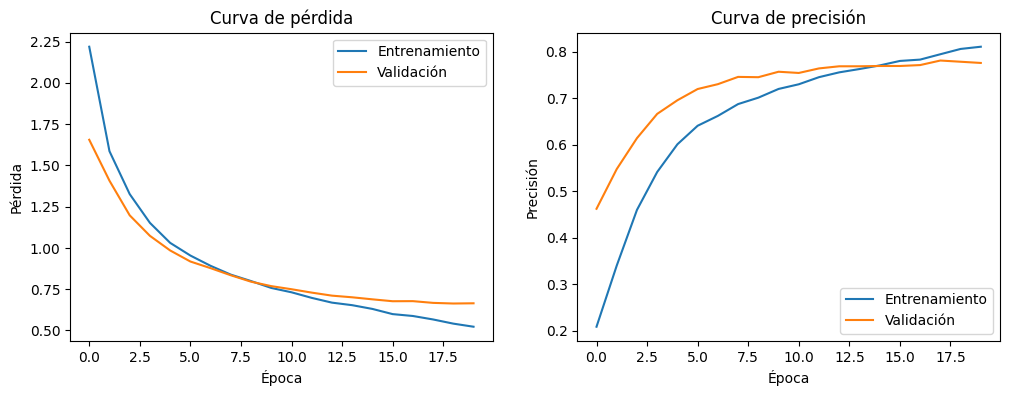

In [45]:
import matplotlib.pyplot as plt


train_loss = historyRoberta7Emotions_lemmatized.history['loss']
val_loss = historyRoberta7Emotions_lemmatized.history['val_loss']
train_accuracy = historyRoberta7Emotions_lemmatized.history['accuracy']
val_accuracy = historyRoberta7Emotions_lemmatized.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

# With 7 emotions 3 dataset concatenated with limit 1312 data

In [4]:
isear = pd.read_excel('ISEAR.xlsx')


print(isear.head())


      ID  CITY  COUN  SUBJ  SEX  AGE  RELI  PRAC  FOCC  MOCC  ...  SELF  RELA  \
0  11001     1     1     1    1   33     1     2     6     1  ...     3     3   
1  11001     1     1     1    1   33     1     2     6     1  ...     2     2   
2  11001     1     1     1    1   33     1     2     6     1  ...     2     1   
3  11001     1     1     1    1   33     1     2     6     1  ...     1     1   
4  11001     1     1     1    1   33     1     2     6     1  ...     0     2   

   VERBAL  NEUTRO   Field1  Field3  Field2   MYKEY  \
0       2       0      joy       4       3  110011   
1       0       0     fear       3       2  110012   
2       0       0    anger       1       3  110013   
3       0       2  sadness       4       4  110014   
4       0       0  disgust       4       4  110015   

                                                 SIT  STATE  
0  During the period of falling in love, each tim...      1  
1         When I was involved in a traffic accident.      1  
2 

In [5]:
isearDataset = isear.iloc[:, [40,36]]
isearDataset = isearDataset.rename(columns={'Field1': 'label', 'SIT': 'texto'})
isearDataset

,texto,label
0,"During the period of falling in love, each tim...",joy
1,When I was involved in a traffic accident.,fear
2,When I was driving home after several days of...,anger
3,When I lost the person who meant the most to me.,sadness
4,The time I knocked a deer down - the sight of ...,disgust
...,...,...
7661,Two years back someone invited me to be the tu...,anger
7662,I had taken the responsibility to do something...,sadness
7663,I was at home and I heard a loud sound of spit...,disgust
7664,I did not do the homework that the teacher had...,shame


In [6]:
def eliminarAcentos(texto):
    texto = texto.replace('á', '')
    texto = texto.replace('\n', '')
    return texto
isearDataset['texto'] = isearDataset['texto'].apply(eliminarAcentos)

In [7]:
isearDataset = isearDataset.replace(to_replace=['joy', 'anger', 'sadness'], value=['happy', 'angry', 'sad']) #Reemplazar nombres de datos
isearDataset = isearDataset.drop(isearDataset[isearDataset['label']== 'shame'].index) #Eliminar nombres de datos de emociones que no se ocupan
isearDataset = isearDataset.drop(isearDataset[isearDataset['label']== 'guilt'].index)
isearDataset = isearDataset.drop(isearDataset[isearDataset['label']== 'guit'].index)
isearDataset = isearDataset.reset_index(drop=True)
isearDataset

,texto,label
0,"During the period of falling in love, each tim...",happy
1,When I was involved in a traffic accident.,fear
2,When I was driving home after several days of...,angry
3,When I lost the person who meant the most to me.,sad
4,The time I knocked a deer down - the sight of ...,disgust
...,...,...
5472,I received a letter from a distant friend.,happy
5473,My parents were out and I was the eldest at ho...,fear
5474,Two years back someone invited me to be the tu...,angry
5475,I had taken the responsibility to do something...,sad


In [8]:
dfMeld=pd.read_csv('meld_train.csv')

label = dfMeld['Emotion']
text = dfMeld['Utterance']

data = {
    'texto' : text.tolist(),
    'label' : label.tolist()
}

dfMeld= pd.DataFrame(data)

In [9]:
dfMeld['label'].value_counts()

label
neutral     4710
joy         1743
surprise    1205
anger       1109
sadness      683
disgust      271
fear         268
Name: count, dtype: int64

In [10]:
dfMeld = dfMeld.replace(to_replace=['joy', 'sadness', 'anger'], value=['happy', 'sad', 'angry'])
dfMeld

def eliminarAcentos(texto):
    texto = texto.replace('[]', "'")
    texto = texto.replace('', "'")
    return texto
dfMeld['texto'] = dfMeld['texto'].apply(eliminarAcentos)
dfMeld


,texto,label
0,also I was the point person on my company's tr...,neutral
1,You must've had your hands full.,neutral
2,That I did. That I did.,neutral
3,So let's talk a little bit about your duties.,neutral
4,My duties? All right.,surprise
...,...,...
9984,You or me?,neutral
9985,"I got it. Uh, Joey, women don't have Adam's ap...",neutral
9986,"You guys are messing with me, right?",surprise
9987,Yeah.,neutral


In [11]:
iemocapDataset = pd.read_csv('df_filters.csv')
iemocapDataset

,Texto,Emoción
0,Excuse me.,neutral
1,Yeah.,neutral
2,Is there a problem?,neutral
3,Well what's the problem? Let me change it.,neutral
4,That's out of control.,angry
...,...,...
4632,oh! Marry you again? I wouldn't marry you agai...,angry
4633,Beast,angry
4634,You're a wicked little vampire. And I pray to ...,angry
4635,Brute,angry


In [12]:
iemocapDataset['Emoción'].unique()

array(['neutral', 'angry', 'sad', 'happy', 'surprise', 'fear', 'disgust'],
      dtype=object)

In [13]:
iemocapDataset = iemocapDataset.rename(columns={'Emoción': 'label', 'Texto':'texto'})
iemocapDataset

,texto,label
0,Excuse me.,neutral
1,Yeah.,neutral
2,Is there a problem?,neutral
3,Well what's the problem? Let me change it.,neutral
4,That's out of control.,angry
...,...,...
4632,oh! Marry you again? I wouldn't marry you agai...,angry
4633,Beast,angry
4634,You're a wicked little vampire. And I pray to ...,angry
4635,Brute,angry


In [14]:
dfMeld['label'].value_counts()

label
neutral     4710
happy       1743
surprise    1205
angry       1109
sad          683
disgust      271
fear         268
Name: count, dtype: int64

In [15]:
isearDataset['label'].value_counts()

label
angry      1096
sad        1096
disgust    1096
fear       1095
happy      1094
Name: count, dtype: int64

In [16]:
iemocapDataset['label'].value_counts()

label
neutral     1707
angry       1103
sad         1083
happy        595
surprise     107
fear          40
disgust        2
Name: count, dtype: int64

In [14]:
IemocapCantidad = iemocapDataset[iemocapDataset['label']=='neutral'].sample(2, random_state=42)
IemocapCantidad

,texto,label
1330,"If I laugh at everything, then I must laugh at...",neutral
3669,"Well, I have no camera here. I can't help you ...",neutral


In [16]:
len(isearDataset[isearDataset['label']=='neutral'])

0

In [15]:
import pandas as pd

objetivo = {
    'neutral': 1310,
    'angry': 1312,
    'sad': 1312,
    'happy': 1310,
    'surprise': 1311,
    'fear': 1311,
    'disgust': 1312
}


dftodo = pd.DataFrame(columns=['texto', 'label'])

for clase in objetivo.keys():
    number = objetivo[clase]
    actual = len(isearDataset[isearDataset['label'] == clase])
    faltante = number - actual
    meldCantidad = len(dfMeld[dfMeld['label'] == clase])
    print("Faltante 1", faltante)
    print("clase:", clase)
    print("CantidadMeld", meldCantidad)

    if actual == 0 and faltante == number:
        if meldCantidad >= number:
            meldCantidadEntrega = dfMeld[dfMeld['label'] == clase].sample(number, random_state=42)
            dftodo = pd.concat([dftodo, meldCantidadEntrega], axis=0)
            faltante -= len(meldCantidadEntrega)
        else:
            meldCantidadEntrega = dfMeld[dfMeld['label'] == clase]
            dftodo = pd.concat([dftodo, meldCantidadEntrega], axis=0)
            faltante = len(dftodo[dftodo['label']==clase])
            if faltante < number:
                faltante = number-faltante
                IemocapCantidad = iemocapDataset[iemocapDataset['label']==clase].sample(faltante, random_state=42)
                dftodo = pd.concat([dftodo, IemocapCantidad], axis=0)
                faltante = len(dftodo[dftodo['label']==clase])
            continue


    while faltante > 0:
        if meldCantidad <= faltante:
            meldCantidadEntrega = dfMeld[dfMeld['label'] == clase].sample(meldCantidad, random_state=42)
            isearDataset_necesario = isearDataset[isearDataset['label'] == clase]
            dftodo = pd.concat([dftodo, isearDataset_necesario, meldCantidadEntrega], axis=0)
            dftodo_largo = len(dftodo[dftodo['label'] == clase])
            print("FALTANTE MELD1", dftodo_largo)
            if dftodo_largo < number:
                actual2 = len(dftodo[dftodo['label'] == clase])
                faltante2 = number - actual2
                IemocapCantidad = iemocapDataset[iemocapDataset['label'] == clase].sample(faltante2, random_state=42)
                dftodo = pd.concat([dftodo, IemocapCantidad], axis=0)
                faltante = number - len(dftodo[dftodo['label'] == clase])
                print("FALTANTE IEMOCAP", faltante)
                if faltante == 0:
                    print("Se terminó")
                    break
            else:
                if dftodo_largo == number:
                    break
        else:
            meldCantidadEntrega = dfMeld[dfMeld['label'] == clase].sample(faltante, random_state=42)
            isearDataset_necesario = isearDataset[isearDataset['label'] == clase]
            dftodo = pd.concat([dftodo, isearDataset_necesario, meldCantidadEntrega], axis=0)
            faltante = number - len(dftodo[dftodo['label'] == clase])
            print("actual MELD2", len(dftodo[dftodo['label'] == clase]))
            if faltante == 0:
                break


print(dftodo['label'].value_counts())



Faltante 1 1310
clase: neutral
CantidadMeld 4710
Faltante 1 216
clase: angry
CantidadMeld 1109
actual MELD2 1312
Faltante 1 216
clase: sad
CantidadMeld 683
actual MELD2 1312
Faltante 1 216
clase: happy
CantidadMeld 1743
actual MELD2 1310
Faltante 1 1311
clase: surprise
CantidadMeld 1205
Faltante 1 216
clase: fear
CantidadMeld 268
actual MELD2 1311
Faltante 1 216
clase: disgust
CantidadMeld 271
actual MELD2 1312
label
angry       1312
sad         1312
disgust     1312
surprise    1311
fear        1311
neutral     1310
happy       1310
Name: count, dtype: int64


In [16]:
dftodo['label'].value_counts()

label
angry       1312
sad         1312
disgust     1312
surprise    1311
fear        1311
neutral     1310
happy       1310
Name: count, dtype: int64

In [17]:
dftodo.reset_index(inplace=True,drop=True)
dftodo

,texto,label
0,"Now, have you told anyone else?",neutral
1,No.,neutral
2,"No thanks, I've already seen one.",neutral
3,"No, answer his.",neutral
4,"Y'know, twin stuff is always a real big seller.",neutral
...,...,...
9173,We've got the ground-up flesh of formerly cute...,disgust
9174,"But I stand by my review, I know food and that...",disgust
9175,Oh no.,disgust
9176,"What are you talking about?! Mindy, the guy is...",disgust


In [30]:
dftodo['label'].value_counts()

label
angry       1312
sad         1312
disgust     1312
surprise    1311
fear        1311
neutral     1310
happy       1310
Name: count, dtype: int64

In [18]:
import re
import spacy

nlp = spacy.load("en_core_web_sm") 

def clean_emotion_text(texto):
    if isinstance(texto, list): 
        texto = texto[0] 

    if texto.startswith('[') and texto.endswith(']'): 
        texto = texto[1:-1]

    texto = texto.lower()

    texto = texto.replace('á', '')
    texto = texto.replace('\n', '')
    texto = texto.replace('[]', "'")
    texto = texto.replace('', "'")

    texto = re.sub(r"@[A-Za-z0-9]+", ' ', texto)
    texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)
    texto = re.sub(r"[^a-zA-Z.'!?]", ' ', texto)
    texto = re.sub(r"#", ' ', texto)
    texto = re.sub(r"\s(?=\')", "", texto) 
    texto = texto.replace("' ", "'")
    texto = re.sub(r" +", ' ', texto)

    return texto


texto_clean = [clean_emotion_text(text) for text in tqdm(dftodo['texto'])]

100%|██████████| 9178/9178 [00:00<00:00, 60575.62it/s]


In [19]:
labels = dftodo['label']

le = LabelEncoder()

labelEncoder = le.fit_transform(labels)

data_labels = labelEncoder

In [20]:
# get the class names
class_names = le.classes_

# get the numerics values assigned to each classes
class_values = le.transform(class_names)

# show the class names and their numerics values
for name, value in zip(class_names, class_values):
    print(f'Clase: {name}, Valor: {value}')

Clase: angry, Valor: 0
Clase: disgust, Valor: 1
Clase: fear, Valor: 2
Clase: happy, Valor: 3
Clase: neutral, Valor: 4
Clase: sad, Valor: 5
Clase: surprise, Valor: 6


In [21]:
x_train, x_test, y_train, y_test = train_test_split(texto_clean, data_labels, random_state=42, stratify=data_labels, test_size=0.1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=42, stratify=y_train, test_size=0.2222)


In [22]:
from textattack.augmentation import EasyDataAugmenter
from tqdm import tqdm
import random
import numpy as np


# create augmenter
augmenter = EasyDataAugmenter()

# Function to apply the text augmentation
def augment_text(text, label):
    set_seed(42)
    augmented_texts = augmenter.augment(text)
    augmented_data = [(augmented_text, label) for augmented_text in augmented_texts]
    return augmented_data

# Convert zip result to list
data_with_labels = list(zip(x_train, y_train))

# Apply text aumentation to each text in texto_clean
augmented_data_list = [augment_text(text, label) for text, label in tqdm(data_with_labels, total=len(data_with_labels))]

# Flatten the list of list
augmented_data_flat = [item for sublist in augmented_data_list for item in sublist]

# Extract the generated phrases and labels
x_train_augmented = [augmented_text for augmented_text, label in augmented_data_flat]
y_train_augmented = [label for augmented_text, label in augmented_data_flat]


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
100%|██████████| 6424/6424 [15:03<00:00,  7.11it/s]  


In [23]:
import re
import spacy
from nltk.corpus import words
nltk.download('words')



nlp = spacy.load("en_core_web_sm") #Spacy model english text
valid_words = set(words.words())  

def correct_ii_errors(text):
    words = text.split()
    corrected_words = []
    for word in words:
        if 'ii' in word.lower() and word.lower() not in valid_words:
            corrected_word = word.replace('ii', 'i')
            if corrected_word.lower() in valid_words:
                corrected_words.append(corrected_word)
            else:
                corrected_words.append(word)
        else:
            corrected_words.append(word)
    return ' '.join(corrected_words)

def clean_emotion_text(texto):
    if isinstance(texto, list): 
        texto = texto[0] 

    if texto.startswith('[') and texto.endswith(']'): 
        texto = texto[1:-1]

    texto = texto.lower()

    texto = texto.replace('á', '')
    texto = texto.replace('\n', '')
    texto = texto.replace('[]', "'")
    texto = texto.replace('', "'")

    texto = re.sub(r"@[A-Za-z0-9]+", ' ', texto)
    texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)
    texto = re.sub(r"[^a-zA-Z.'!?]", ' ', texto)
    texto = re.sub(r"(?<!\S)\?(?!\S)", '', texto)
    texto = re.sub(r"(?<!\S)\.(?!\S)", '', texto)
    texto = re.sub(r"#", ' ', texto)
    texto = re.sub(r"\s(?=\')", "", texto) 
    texto = texto.replace("' ", "'")
    texto = re.sub(r" +", ' ', texto)

    corrected_text = correct_ii_errors(texto)  

    return corrected_text

# Llamado a la función de limpieza
x_train_augmentedwith = [clean_emotion_text(text) for text in tqdm(x_train_augmented)]

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
100%|██████████| 24905/24905 [00:00<00:00, 36265.78it/s]


In [24]:
#Save Augmented data

import pandas as pd

df_augmented = pd.DataFrame({'Texto': x_train_augmentedwith, 'Label': y_train_augmented})

df_augmented.to_csv('datos_aumentados_lemmatized_MoreDatawith7emotionsMoreData.csv', index=False)

In [25]:
import pandas as pd

# Load the csv file into a dataframe
df_recuperado = pd.read_csv('datos_aumentados_lemmatized_MoreDatawith7emotionsMoreData.csv')

# Get the augmented data and labels
x_train_augmented = df_recuperado['Texto'].tolist()
y_train_augmented = df_recuperado['Label'].tolist()

In [26]:
from transformers import BertTokenizer, TFBertModel,RobertaTokenizer,TFRobertaModel

tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

tokenizer_roberta = RobertaTokenizer.from_pretrained("FacebookAI/roberta-base")
roberta_model = TFRobertaModel.from_pretrained("FacebookAI/roberta-base")



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [27]:
def tokenizer_roberta_fn(texts, labels):
    input_ids = []
    attention_masks = []
    label_array = tf.one_hot(labels, depth=7)

    for text in texts:
        inputs = tokenizer_roberta(text, 
                                padding="max_length", 
                                truncation=True,
                                max_length=300,
                                return_tensors='tf')
        input_ids.append(inputs['input_ids'])
        attention_masks.append(inputs['attention_mask'])

    return np.array(input_ids), np.array(attention_masks), label_array

input_ids_train_roberta_lemmatitized_moreData, attention_mask_train_roberta_lemmatitized_moreData, labels_train_roberta_lemmatitized_moreData = tokenizer_roberta_fn(x_train_augmented, y_train_augmented)
input_ids_test_roberta_lemmatitized_moreData, attention_mask_test_roberta_lemmatitized_moreData, labels_test_roberta_lemmatitized_moreData, = tokenizer_roberta_fn(x_test, y_test)
input_ids_val_roberta_lemmatitized_moreData, attention_mask_val_roberta_lemmatitized_moreData, labels_val_roberta_lemmatitized_moreData, = tokenizer_roberta_fn(x_val, y_val)

input_ids_train_roberta_lemmatitized_moreData = np.squeeze(input_ids_train_roberta_lemmatitized_moreData, axis=1)
attention_mask_train_roberta_lemmatitized_moreData = np.squeeze(attention_mask_train_roberta_lemmatitized_moreData, axis=1)

input_ids_test_roberta_lemmatitized_moreData = np.squeeze(input_ids_test_roberta_lemmatitized_moreData, axis=1)
attention_mask_test_roberta_lemmatitized_moreData = np.squeeze(attention_mask_test_roberta_lemmatitized_moreData, axis=1)

input_ids_val_roberta_lemmatitized_moreData = np.squeeze(input_ids_val_roberta_lemmatitized_moreData, axis=1)
attention_mask_val_roberta_lemmatitized_moreData = np.squeeze(attention_mask_val_roberta_lemmatitized_moreData, axis=1)


In [28]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
roberta_output = roberta_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(roberta_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(roberta_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(roberta_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout)
modelTestRoberta7Emotions_lemmatized_MoreData = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

modelTestRoberta7Emotions_lemmatized_MoreData.layers[2].trainable=False

modelTestRoberta7Emotions_lemmatized_MoreData.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
modelTestRoberta7Emotions_lemmatized_MoreData.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                           

In [29]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/lemmatized_MoreData/128batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/lemmatized_MoreData/128batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/lemmatized_MoreData/128batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/lemmatized_MoreData/128batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


#--------------------------------------------------------------------------------
historyRoberta7Emotions_lemmatized_MoreData = modelTestRoberta7Emotions_lemmatized_MoreData.fit(
    [input_ids_train_roberta_lemmatitized_moreData, attention_mask_train_roberta_lemmatitized_moreData], labels_train_roberta_lemmatitized_moreData,
    validation_data=([input_ids_val_roberta_lemmatitized_moreData, attention_mask_val_roberta_lemmatitized_moreData], labels_val_roberta_lemmatitized_moreData),
    epochs=20,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=128, shuffle=True
)


#print(model23.evaluate([input_ids_test, attention_mask_test], labels_test))

Epoch 1/20
195/195 [==============================] - ETA: 0s - loss: 2.1977 - accuracy: 0.2120 - recall: 0.0485
Epoch 1: val_accuracy improved from -inf to 0.41285, saving model to model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/lemmatized_MoreData/128batch\BERT_CNN_model_best_01_val_0.4129.h5
195/195 [==============================] - 422s 2s/step - loss: 2.1977 - accuracy: 0.2120 - recall: 0.0485 - val_loss: 1.7135 - val_accuracy: 0.4129 - val_recall: 0.0000e+00
Epoch 2/20
195/195 [==============================] - ETA: 0s - loss: 1.6712 - accuracy: 0.3306 - recall: 0.0608
Epoch 2: val_accuracy improved from 0.41285 to 0.53486, saving model to model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/lemmatized_MoreData/128batch\BERT_CNN_model_best_02_val_0.5349.h5
195/195 [==============================] - 405s 2s/step - loss: 1.6712 - accuracy: 0.3306 - recall: 0.0608 - val_loss: 1.5570 - val_accuracy: 0.5349 - val_recall: 0.0000e+00
Epoch 3/20
195/195 [=========

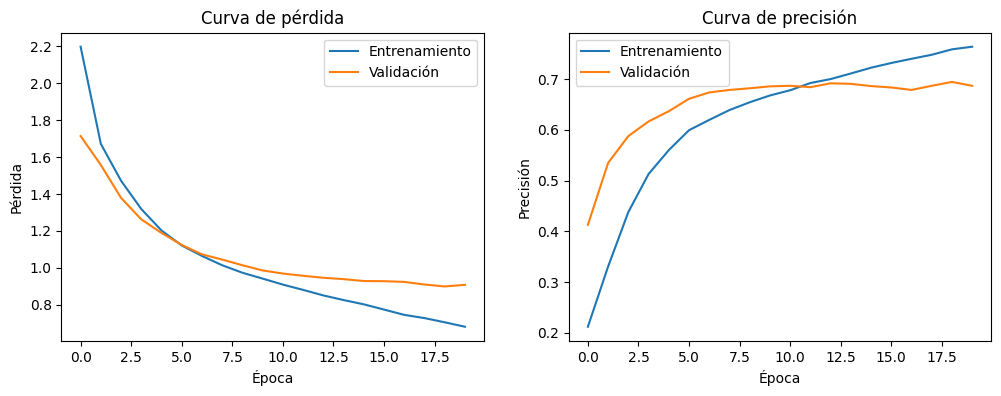

In [30]:
import matplotlib.pyplot as plt


train_loss = historyRoberta7Emotions_lemmatized_MoreData.history['loss']
val_loss = historyRoberta7Emotions_lemmatized_MoreData.history['val_loss']
train_accuracy = historyRoberta7Emotions_lemmatized_MoreData.history['accuracy']
val_accuracy = historyRoberta7Emotions_lemmatized_MoreData.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()